In [1]:
from datetime import datetime
import dask.array as da
import os
import time
import h5py
import glob
import numpy as np
import xarray as xr

import pandas as pd
import geopandas as gpd
import scipy.stats as stats
from scipy.stats import spearmanr

import downscale as down

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.interpolate import RegularGridInterpolator

from scipy.stats import weibull_min
from scipy.optimize import curve_fit, minimize, fsolve
from scipy.optimize import differential_evolution

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

from playsound import playsound

%run ../function/functions.ipynb

import warnings
warnings.filterwarnings('ignore')

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


## Test beta for IMERG data in Veneto

In [2]:
name, yy_s, yy_e = 'Coast Level', 2001, 2017
# name, yy_s, yy_e = 'Low Level', 2001, 2014
# name, yy_s, yy_e = 'Medium Level', 2001, 2017
# name, yy_s, yy_e = 'High Level', 2001, 2022

maxmiss = 40

In [3]:
npix = 5 # each pixel is 10 km, with odd number the center is simetric (3, 5, 7 and 9)

thresh = 1 # default
# thresh = 2 
# thresh = 2.6 
# thresh = 3
# thresh = 4 
# thresh = 5 
# thresh = 6 
# thresh = 7
# thresh = 8

res = {} # Output dictionary with all information

In [4]:
CONDITION = 'OVERLEAP'; fig_val = 'OVERLAP'
# CONDITION = 'NONOVERLAP'; fig_val = 'NOVERLAP'
# CONDITION = 'FOCUS'; fig_val = 'FOCUS'
print(f'Using condition {CONDITION} for scales aggregation')

Using condition OVERLEAP for scales aggregation


In [5]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy','Veneto.geojson')

if os.path.exists(veneto_dir):
    Veneto = gpd.read_file(veneto_dir)
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [6]:
data_dir = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite','IMERG','3_hour',f'IMERG_Veneto_3h_2001_01_01_2023_12_31.nc')

if os.path.exists(data_dir):
    DATA = xr.open_dataset(data_dir)
    DATA = DATA.sel(time=DATA.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))
else:
    raise SystemExit(f"File not found: {data_dir}")

lats = DATA['lat'].data
lons = DATA['lon'].data

lon2d, lat2d = np.meshgrid(lons, lats)

nlon_ref = np.size(lons)
nlat_ref = np.size(lats)

dx = np.abs(lons[1] - lons[0])
dy = np.abs(lats[1] - lats[0])

DATES = DATA['time'][:]

dset = np.array(DATA['PRE'])
dset[dset==np.nanmin(dset)]=0

DATA

<xarray.Dataset> Size: 477MB
Dimensions:  (time: 49672, lat: 30, lon: 40)
Coordinates:
  * time     (time) datetime64[ns] 397kB 2001-01-01 ... 2017-12-31T21:00:00
  * lat      (lat) float32 120B 44.05 44.15 44.25 44.35 ... 46.75 46.85 46.95
  * lon      (lon) float32 160B 10.05 10.15 10.25 10.35 ... 13.75 13.85 13.95
Data variables:
    PRE      (time, lat, lon) float64 477MB 0.0 0.0 0.0 0.0 ... 3.49 6.59 4.64
Attributes:
    description:  IMERG 3 hour data for Veneto region

In [7]:
PRE_daily = DATA.resample(time ='D').sum(dim='time', skipna=False)
DATES_daily = PRE_daily['time']

## Load Raingauge

In [8]:
rain_dir = os.path.join('/','media','arturo','Arturo','Data','Italy','stations','data','Veneto')

if os.path.exists(rain_dir):
    RAIN = pd.read_csv(os.path.join(rain_dir, 'QC_stations_coords_utm32.csv'), sep=';')
else:
    raise SystemExit(f"File not found: {rain_dir}")

if name == 'Coast Level':
    Id_station = '338_RO_Co.csv'
elif name == 'Low Level':
    Id_station = '274_VR_Mo.csv'
elif name == 'Medium Level':
    Id_station = '343_BL_Fo.csv'
elif name == 'High Level':
    Id_station = '348_NP_Ro.csv'
else:
    print('ERROR: Id dont found')

print(f'{name} station')
CL_INFO = RAIN[RAIN['File_Name']==Id_station]

CL_RAIN = pd.read_csv(os.path.join(rain_dir, 'Dati_QC_30min', CL_INFO['File_Name'].values[0]), sep=';')
CL_RAIN['dataora'] = pd.to_datetime(CL_RAIN['dataora'])
CL_RAIN['yy'] = pd.to_datetime(CL_RAIN['dataora']).dt.year
CL_RAIN['mm'] = pd.to_datetime(CL_RAIN['dataora']).dt.month
CL_RAIN['dd'] = pd.to_datetime(CL_RAIN['dataora']).dt.day
CL_RAIN['hh'] = pd.to_datetime(CL_RAIN['dataora']).dt.hour
CL_RAIN['mm'] = pd.to_datetime(CL_RAIN['dataora']).dt.minute

CL_RAIN[CL_RAIN['valore']>200] = 0

CL_RAIN.tail(3)

Coast Level station


,dataora,valore,qualita,yy,mm,dd,hh
528403,2017-11-30 10:00:00,0.0,1.0,2017,0,30,10
528404,2017-11-30 10:30:00,0.0,1.0,2017,30,30,10
528405,2017-11-30 11:00:00,0.0,1.0,2017,0,30,11


In [9]:
CL_RAIN['dataora'] = pd.to_datetime(CL_RAIN['dataora'])
CL_RAIN.set_index('dataora', inplace=True)

In [10]:
CL_RAIN = CL_RAIN[(CL_RAIN['yy']>=yy_s)&(CL_RAIN['yy']<=yy_e)]
OBS_ACUM = CL_RAIN['valore'].resample('D').sum()
OBS_1DY = pd.DataFrame({'PRE':OBS_ACUM.values, 'TIME':pd.to_datetime(OBS_ACUM.index)})

In [11]:
print(f'Station start time: {CL_RAIN.index[0]}')
print(f'Station end time  : {CL_RAIN.index[-1]}')

Station start time: 2001-01-01 00:00:00
Station end time  : 2017-11-30 11:00:00


In [12]:
print(f'Number of OBS time  : {len(OBS_1DY)}')
print(f'Number of IMERG time: {len(DATES_daily)}')

Number of OBS time  : 6178
Number of IMERG time: 6209


In [13]:
TIME_REF = pd.date_range(start=f'{yy_s}-01-01', end=f'{yy_e}-12-31', freq='d')
TIME_PD = pd.DataFrame({'TIME':TIME_REF})

In [14]:
OBS_1dy_df = xr.DataArray(OBS_1DY['PRE'].values,  coords={'time':OBS_1DY['TIME'].values}, dims=('time'))
OBS_1dy_df = pd.DataFrame({'TIME':OBS_1dy_df['time'].data, 'PRCP':OBS_1dy_df.data})
OBS_1dy_df.shape

(6178, 2)

In [ ]:
if len(OBS_1dy_df) < len(TIME_REF):
    print('WARNING: RAINGAUGE time is not complete. fill times with NaN')
    OBS_TMP = pd.merge(OBS_1dy_df, TIME_PD, on='TIME', how='right')
    OBS_xr = xr.DataArray(OBS_TMP['PRCP'].values,  coords={'time':OBS_TMP['TIME'].values}, dims=('time'))
elif len(OBS_1dy_df) == len(TIME_REF):
    print('GOOD: RAINGAUGE has certain times!!')
    OBS_xr = xr.DataArray(OBS_1dy_df['PRCP'].values,  coords={'time':OBS_1dy_df['TIME'].values}, dims=('time'))
else:
    print('ERROR: RAINGAUGE has too much times, verify!!')
    OBS_xr = xr.DataArray(OBS_1dy_df['PRCP'].values,  coords={'time':OBS_1dy_df['TIME'].values}, dims=('time'))
    print(f'OBS lenght : {len(OBS_1dy_df)}')
    print(f'TIME lenght: {len(TIME_REF)}')

In [16]:
OBS_NCW_1dy, OBS_YEARS = down.fit_yearly_weibull(OBS_xr, thresh=1, maxmiss=maxmiss)
OBS_N, OBS_C, OBS_W = down.wei_fit(OBS_1dy_df.PRCP.values, 1)

In [17]:
distances = haversine(lat2d, lon2d, CL_INFO['Lat'].values[0],CL_INFO['Lon'].values[0])

min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

clat = lats[min_index[0]]
clon = lons[min_index[1]]

TRMM_ML = dset[:,min_index[0],min_index[1]]

print(f"Nearest IMERG lat: {clat}")
print(f'Station lat       : {CL_INFO['Lat'].values[0]}')
print()
print(f"Nearest IMERG lon: {clon}")
print(f'Station lon       : {CL_INFO['Lon'].values[0]}')

Nearest IMERG lat: 45.04999923706055
Station lat       : 45.00466666

Nearest IMERG lon: 12.25
Station lon       : 12.24819444


In [18]:
IMERG_pixel_3h = dset[:,min_index[0],min_index[1]] # time, lat, lon
IMERG_pixel_1dy = PRE_daily['PRE'][:,min_index[0],min_index[1]].data

## Input Parameters

In [19]:
buffer = 0.5*npix*0.1 # To define the limitis of box_3h

L1 = 10
L0 = 0.001 #default 0.0001 = 0.1 meters

dt = 3 # time scale of the precipitation product [HOURS] (default 3 hours)

origin_x = 10 # linear spatial scale of origin gridded prcp [km] (default 25)
origin_t = 24 # time scale of origin gridded pecip [HOURS] (default 24 hours)

target_x = 0.0001 # subgrid spatial scale we want pwet at [km](default 0.0001 km)
target_t = 24 # target time scale, in [HOURS] (default 24 hours)

ninterp = 2000 # number of interpolation in time dimension

cube1size = 5 # lateral size of cube used to decide among how many single pixel average at smallest scale
tmax = 48 # maximum time scale of integration [HOURS]

toll=0.005 # tolerence for optimization of downscaled correlation (default 0.005)

acf='str' # acf='mar' for the power-law described in Marani 2003 (default), acf='str' for a stretched exponential acf (Villarini et al)

In [20]:
# Original data 3h time resolution
test = np.swapaxes(dset, 0, 2)
xrs0 = xr.DataArray(test,  coords={'lon':lons, 'lat':lats, 'time':DATES.data}, dims=('lon', 'lat', 'time'))
xrs = xrs0.where(xrs0 >= -0.001)

del test

In [21]:
eps = 1e-4 # to make sure to include limtis -> add an eps buffer
solat = clat - buffer + eps
nolat = clat + buffer + eps
ealon = clon + buffer + eps
welon = clon - buffer + eps
bcond = np.logical_and(
            np.logical_and( xrs.lat > solat, xrs.lat < nolat),
            np.logical_and( xrs.lon > welon, xrs.lon < ealon))

In [22]:
# Box 3h time resolution
box_3h = xrs.where(bcond, drop = True).load()

box_lon2d, box_lat2d = np.meshgrid(box_3h['lon'].data, box_3h['lat'].data)
nlon = len(box_3h['lon'].data)
nlat = len(box_3h['lat'].data)

if nlon != nlat:
    print('downscale warning: box sizes are not equal')
if nlon % 2 == 0:
    print('downscale warning: at least one box size has even length')
if (bool(clat) and bool(clon) and clat in lats and clon in lons):
    clat = lats[np.argmin(np.abs(clat - lats))]
    clon = lons[np.argmin(np.abs(clon - lons))]
else:
    clat = lats[np.argmin(np.abs(np.mean(lats) - lats))]
    clon = lons[np.argmin(np.abs(np.mean(lons) - lons))]

box_3h.shape

(5, 5, 49672)

In [23]:
# daily time resolution
xdaily0 = box_3h.resample(time ='{}h'.format(24)).sum(dim='time', skipna=False)
xdaily = xdaily0.dropna(dim='time', how='any')

## Define Wet days series

In [24]:
tsc = xdaily.loc[dict(lat = clat, lon = clon)]

# # c_excesses = np.maximum(tsc.values-thresh, 0.0)
c_excesses = tsc[tsc > thresh]
# c_excesses = tsc[tsc > thresh] - thresh
# # c_excesses = tsc.values

# daily time resolution weibull fit
NCW = down.wei_fit(c_excesses, 1)
Ns = NCW[0]
Cs = NCW[1]
Ws = NCW[2]

print(f'Weibull Parameters: {Ns, Cs, Ws}')

Weibull Parameters: (2559, 11.032504633605283, 0.7688500452249761)


Export as: ../fig/Veneto_IMERG_mean.png


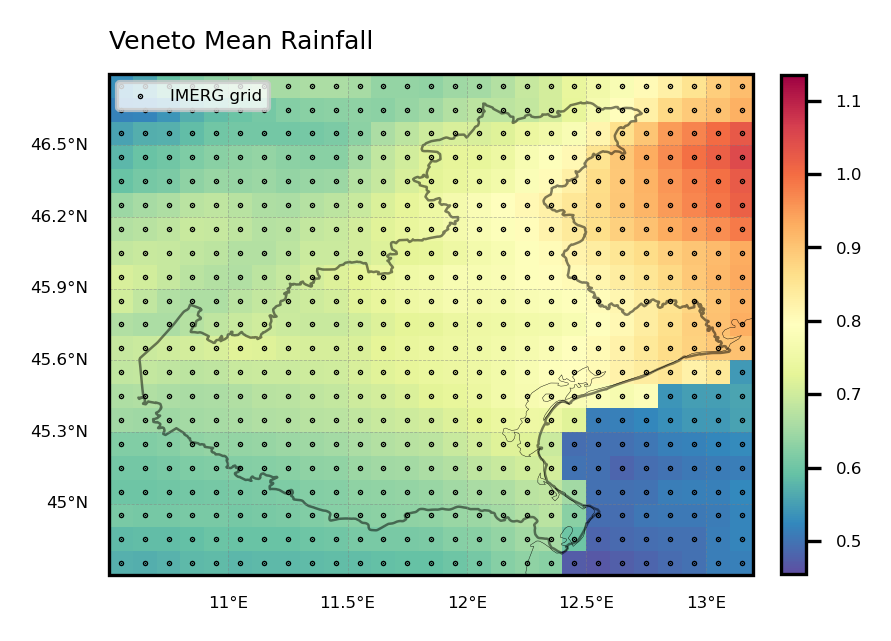

In [25]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(3,3),dpi=300)
gs = gridspec.GridSpec(1,1)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.8], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.6, alpha=0.5)

a1 = ax1.pcolormesh(lon2d, lat2d, np.nanmean(dset,axis=0),cmap=cmap)

ax1.scatter(lon2d, lat2d, s=0.1, c='k', marker='o', label='IMERG grid')

# ax1.scatter(CL_INFO['Lon'], CL_INFO['Lat'], s=2, c='r', zorder=10, label='Station')
# ax1.scatter(clon, clat, s=2, c='k', zorder=10, label='Nearest Neighbour')

plt.legend(fontsize=4, loc=2)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, pad=0.04, fraction=0.0358)
cbar.ax.tick_params(labelsize=4)

ax1.set_title('Veneto Mean Rainfall', loc='left', fontsize=6)

image_dir = f'../fig/Veneto_IMERG_mean.png'
print(f'Export as: {image_dir}')
# plt.savefig(image_dir,transparent = True,bbox_inches ='tight',pad_inches = 0)

Export as: ../fig/Veneto_IMERG_Coast_Level_2001_2017_scale.png


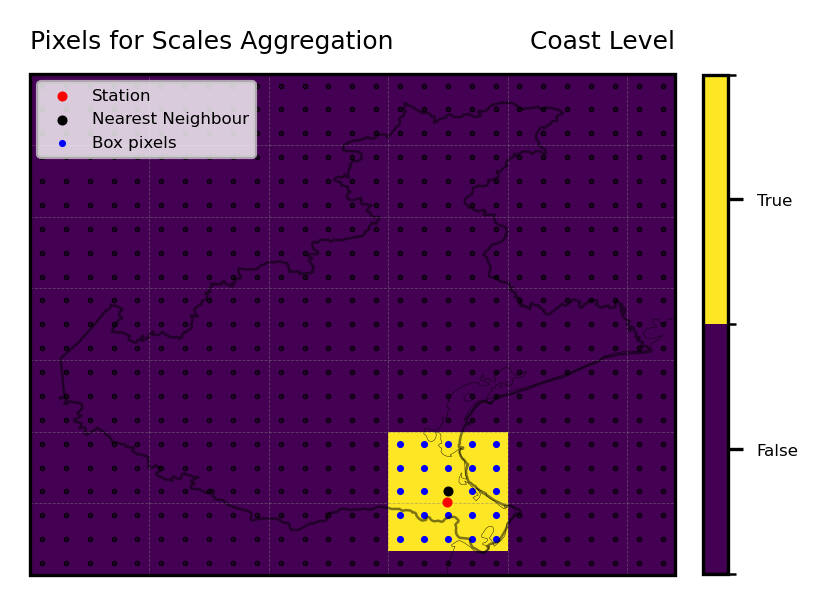

In [26]:
cmap_bin = plt.get_cmap('viridis', 3)  # Use any colormap you like with 2 discrete levels
norm = mcolors.BoundaryNorm([0, 0.5, 1], cmap_bin.N)  

cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(3,3),dpi=300)
gs = gridspec.GridSpec(1,1)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)

ax1.set_extent([10.5, 13.2, 44.7, 46.8], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.6, alpha=0.5)
# a1 = ax1.pcolormesh(lon2d, lat2d, bcond)
a1 = ax1.pcolormesh(lon2d, lat2d, bcond, cmap=cmap_bin, norm=norm)

ax1.scatter(lon2d, lat2d, s=0.1, c='k', marker='o')
ax1.scatter(CL_INFO['Lon'], CL_INFO['Lat'], s=2, c='r', zorder=10, label='Station')
ax1.scatter(clon, clat, s=2, c='k', zorder=10, label='Nearest Neighbour')
ax1.scatter(box_lon2d, box_lat2d, s=0.5, c='b', label='Box pixels')

plt.legend(fontsize=4, loc=2)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, pad=0.04, fraction=0.0358, ticks=[0, 1])
cbar.set_ticks([0.25, 0.75])  
cbar.set_ticklabels(['False', 'True'])
cbar.ax.tick_params(labelsize=4)

ax1.set_title('Pixels for Scales Aggregation', loc='left', fontsize=6)
ax1.set_title(f'{name}',loc='right',fontsize=6)

# ================================================================================================
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.1, wspace=0.12)

image_dir = f'../fig/Veneto_IMERG_{name.replace(' ','_')}_{yy_s}_{yy_e}_scale.png'
print(f'Export as: {image_dir}')
# plt.savefig(image_dir,transparent = True,bbox_inches ='tight',pad_inches = 0)

## Verify the Time Scale Aggregations

In [27]:
smax = box_3h.shape[0] # max spatial scale
tscales = np.array([1, 2, 3, 4, 5, 6, 8, 10, 12, 16, 20, 24, 36, 48, 96])*dt
tscales = tscales[tscales < tmax + 0.001]
xscales = np.arange(1, smax+1)
xscales_km = xscales*L1
ntscales = np.size(tscales)
nsscales = np.size(xscales)
pwets = np.zeros((ntscales, nsscales))

print(f'Maximum Spatial Scale: {smax*L1} km')
print(f'Number of Spatial Scale: {nsscales}')
print()
print(f'Maximum time Scale   : {tmax} h')
print(f'Number of Time Scale: {ntscales}')

Maximum Spatial Scale: 50 km
Number of Spatial Scale: 5

Maximum time Scale   : 48 h
Number of Time Scale: 10


In [28]:
# print(f'Maximum time scales: {len(tscales)}')
# print()
# Stime_mean = []
# Swet_fraction = []
# for it, st in enumerate(tscales):
#     datamat = box_3h.resample(time='{}h'.format(st)).sum(dim='time', skipna = False)
#     Stime_mean_tmp = datamat.mean(dim=('lat', 'lon'), skipna = False).dropna(dim='time', how='any')
#     Stime_mean.append(Stime_mean_tmp)
#     Swet_fraction_tmp = wetfrac(Stime_mean_tmp.data, thresh)
#     Swet_fraction.append(np.round(Swet_fraction_tmp,3))
#     print(f'Scale time: {st} h and wet fraction {np.round(Swet_fraction_tmp,3)}')

## Verify the Time-Spatial Scale Aggregations

In [29]:
rainfall_ref = []
Swet_final = []
Swet_scale = []
print(f'Using condition: {CONDITION}')
print()
for st in tscales:
    datamat = box_3h.resample(time='{}h'.format(st)).sum(dim='time', skipna = False)

    input_data = datamat.copy()

    print(f'Agregation for time scale: {st} hours')
    for ix, sx in enumerate(xscales):
        if sx == 1:
            print(f'Mean wet fraction for scale: {L1} km')
            rain_tmp = np.zeros([nlon, nlat, input_data.shape[2]])
            wet_tmp = np.zeros([nlon, nlat])
            for i in range(nlon):
                for j in range(nlat):
                    wet_tmp[i,j] = wetfrac(input_data[i,j,:].data, thresh)
                    rain_tmp[i,j] = input_data[i,j,:].data
            # print(wet_tmp.mean())
            rainfall_ref.append(np.mean(rain_tmp,axis=(0,1)))
            Swet_final.append(wet_tmp.mean())
            Swet_scale.append(L1)

        elif sx == smax:
            print(f'Mean wet fraction for scale: {L1*smax} km')
            rainfall_tmp = input_data.mean(axis=(0,1))
            wet_tmp = wetfrac(rainfall_tmp, thresh)
            # print(wet_tmp)
            rainfall_ref.append(rainfall_tmp.data)
            Swet_final.append(wet_tmp)
            Swet_scale.append(L1*smax)
        
        elif sx > 1 and sx < smax:
            print(f'Mean wet fraction for scale: {L1*sx} km')
            Swet_fraction = []

            if CONDITION == 'OVERLEAP' or CONDITION == 'NONOVERLAP':
                for i in range(nlon):
                    for j in range(nlat):

                        if CONDITION == 'OVERLEAP':
                            # WITH OVERLAP
                            box_tmp = input_data[i:i+sx,j:j+sx,:]
                        elif CONDITION == 'NONOVERLAP':
                            # WITHOUT OVERLAP
                            box_tmp = input_data[sx*i:sx*i+sx,sx*j:sx*j+sx,:]

                        if box_tmp.shape[0] == sx and box_tmp.shape[1] == sx:
                            wet_tmp = wetfrac(box_tmp.mean(axis=(0,1)).data, thresh)
                            Swet_fraction.append(wet_tmp)

            elif CONDITION == 'FOCUS': # FOR AGREGATION WITH FOCUS IN SPECIFIC POINT (NOW ONLY WORK FOR npix = 5)
                L = sx - 1
                if sx == 2 or sx == 3:
                    origin_x_pos, origin_y_pos = 2, 2
                    for loop in range(4):
                        if loop == 0:
                            box_tmp = input_data[origin_x_pos-1*L:origin_x_pos+1,origin_y_pos-1*L:origin_y_pos+1]
                        elif loop == 1:
                            box_tmp = input_data[origin_x_pos:origin_x+2*L,origin_y_pos-1*L:origin_y_pos+1]
                        elif loop == 2:
                            box_tmp = input_data[origin_x_pos-1*L:origin_x_pos+1,origin_y_pos:origin_y_pos+2*L]
                        elif loop == 3:
                            box_tmp = input_data[origin_x_pos:origin_x_pos+2*L,origin_y_pos:origin_y_pos+2*L]
                        wet_tmp = wetfrac(box_tmp.mean(axis=(0,1)).data, thresh)
                        Swet_fraction.append(wet_tmp)
                
                elif sx == 4:
                    for loop in range(4):
                        if loop == 0:
                            origin_x_pos, origin_y_pos = 3, 3
                            box_tmp = input_data[origin_x_pos-1*L:origin_x_pos+1,origin_y_pos-1*L:origin_y_pos+1]
                        elif loop == 1:
                            origin_x_pos, origin_y_pos = 1, 3
                            tmp_pos_RB = input_data[origin_x_pos:origin_x_pos+2*L,origin_y_pos-1*L:origin_y_pos+1]  
                        elif loop == 2:
                            origin_x_pos, origin_y_pos = 3, 1
                            tmp_pos_LT = input_data[origin_x_pos-1*L:origin_x_pos+1,origin_y_pos:origin_y_pos+2*L]
                        elif loop == 3:
                            origin_x_pos, origin_y_pos = 1, 1
                            tmp_pos_RT = input_data[origin_x_pos:origin_x_pos+2*L,origin_y_pos:origin_y_pos+2*L]
                        wet_tmp = wetfrac(box_tmp.mean(axis=(0,1)).data, thresh)
                        Swet_fraction.append(wet_tmp)

            rainfall_ref.append(box_tmp.sum(axis=(0,1)).data) # Rainfall series
            Swet_final.append(np.mean(Swet_fraction)) # wet fraction
            Swet_scale.append(L1*sx) # Spatial scales
    print()

WET_MATRIX = np.reshape(Swet_final,(10,npix))

Using condition: OVERLEAP

Agregation for time scale: 3 hours
Mean wet fraction for scale: 10 km
Mean wet fraction for scale: 20 km
Mean wet fraction for scale: 30 km
Mean wet fraction for scale: 40 km
Mean wet fraction for scale: 50 km

Agregation for time scale: 6 hours
Mean wet fraction for scale: 10 km
Mean wet fraction for scale: 20 km
Mean wet fraction for scale: 30 km
Mean wet fraction for scale: 40 km
Mean wet fraction for scale: 50 km

Agregation for time scale: 9 hours
Mean wet fraction for scale: 10 km
Mean wet fraction for scale: 20 km
Mean wet fraction for scale: 30 km
Mean wet fraction for scale: 40 km
Mean wet fraction for scale: 50 km

Agregation for time scale: 12 hours
Mean wet fraction for scale: 10 km
Mean wet fraction for scale: 20 km
Mean wet fraction for scale: 30 km
Mean wet fraction for scale: 40 km
Mean wet fraction for scale: 50 km

Agregation for time scale: 15 hours
Mean wet fraction for scale: 10 km
Mean wet fraction for scale: 20 km
Mean wet fraction for 

In [30]:
# sx = 4
# L = sx - 1

# if sx == 2 or sx == 3:
#     # LEFT BOTTOM
#     origin_x, origin_y = 2, 2
#     tmp_pos_LB = input_data[origin_x-1*L:origin_x+1,origin_y-1*L:origin_y+1]
#     grid_2x_tmp_LB, grid_2y_tmp_LB = np.meshgrid(tmp_pos_LB['lon'].data, tmp_pos_LB['lat'].data)

#     # RIGHT BOTTOM
#     tmp_pos_RB = input_data[origin_x:origin_x+2*L,origin_y-1*L:origin_y+1]
#     grid_2x_tmp_RB, grid_2y_tmp_RB = np.meshgrid(tmp_pos_RB['lon'].data, tmp_pos_RB['lat'].data)

#     # LEFT TOP
#     tmp_pos_LT = input_data[origin_x-1*L:origin_x+1,origin_y:origin_y+2*L]
#     grid_2x_tmp_LT, grid_2y_tmp_LT = np.meshgrid(tmp_pos_LT['lon'].data, tmp_pos_LT['lat'].data)

#     # RIGHT TOP
#     tmp_pos_RT = input_data[origin_x:origin_x+2*L,origin_y:origin_y+2*L]
#     grid_2x_tmp_RT, grid_2y_tmp_RT = np.meshgrid(tmp_pos_RT['lon'].data, tmp_pos_RT['lat'].data)

# elif sx == 4:
#     # LEFT BOTTOM
#     origin_x, origin_y = 3, 3
#     tmp_pos_LB = input_data[origin_x-1*L:origin_x+1,origin_y-1*L:origin_y+1]
#     grid_2x_tmp_LB, grid_2y_tmp_LB = np.meshgrid(tmp_pos_LB['lon'].data, tmp_pos_LB['lat'].data)

#     # RIGHT BOTTOM
#     origin_x, origin_y = 1, 3
#     tmp_pos_RB = input_data[origin_x:origin_x+2*L,origin_y-1*L:origin_y+1]
#     grid_2x_tmp_RB, grid_2y_tmp_RB = np.meshgrid(tmp_pos_RB['lon'].data, tmp_pos_RB['lat'].data)

#     # LEFT TOP
#     origin_x, origin_y = 3, 1
#     tmp_pos_LT = input_data[origin_x-1*L:origin_x+1,origin_y:origin_y+2*L]
#     grid_2x_tmp_LT, grid_2y_tmp_LT = np.meshgrid(tmp_pos_LT['lon'].data, tmp_pos_LT['lat'].data)

#     # RIGHT TOP
#     origin_x, origin_y = 1, 1
#     tmp_pos_RT = input_data[origin_x:origin_x+2*L,origin_y:origin_y+2*L]
#     grid_2x_tmp_RT, grid_2y_tmp_RT = np.meshgrid(tmp_pos_RT['lon'].data, tmp_pos_RT['lat'].data)

In [31]:
# grid_2x, grid_2y = np.meshgrid(input_data['lon'], input_data['lat'])

# fig = plt.figure(figsize=(4,4),dpi=300)
# gs = gridspec.GridSpec(2,2)

# # ===================================================================
# ax1 = plt.subplot(gs[0, 0], projection = proj)
# ax1.grid(linestyle='--', linewidth=0.3)

# ax1.scatter(grid_2x, grid_2y, s=10, zorder=2)

# ax1.scatter(input_data['lon'][2], input_data['lat'][2], s=8, c='k', zorder=4)

# ax1.scatter(grid_2x_tmp_LB, grid_2y_tmp_LB, s=3, c='r', zorder=6)

# ax1.set_title('(a) LEFT BOTTOM', loc='left', fontsize=6, pad=2)

# gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
# gl.top_labels = False
# gl.bottom_labels = False
# gl.right_labels = False
# gl.left_labels = True
# gl.xlabel_style = {'size': 4, 'color': 'k'}
# gl.ylabel_style = {'size': 4, 'color': 'k'}

# # ===================================================================
# ax1 = plt.subplot(gs[0, 1], projection = proj)
# ax1.grid(linestyle='--', linewidth=0.3)

# ax1.scatter(grid_2x, grid_2y, s=10, zorder=2)

# ax1.scatter(input_data['lon'][2], input_data['lat'][2], s=8, c='k', zorder=4)

# ax1.scatter(grid_2x_tmp_RB, grid_2y_tmp_RB, s=3, c='r', zorder=6)

# ax1.set_title('(b) RIGHT BOTTOM', loc='left', fontsize=6, pad=2)

# gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
# gl.top_labels = False
# gl.bottom_labels = False
# gl.right_labels = False
# gl.left_labels = False
# gl.xlabel_style = {'size': 4, 'color': 'k'}
# gl.ylabel_style = {'size': 4, 'color': 'k'}

# # ===================================================================
# ax1 = plt.subplot(gs[1, 0], projection = proj)
# ax1.grid(linestyle='--', linewidth=0.3)

# ax1.scatter(grid_2x, grid_2y, s=10, zorder=2)

# ax1.scatter(input_data['lon'][2], input_data['lat'][2], s=8, c='k', zorder=4)

# ax1.scatter(grid_2x_tmp_LT, grid_2y_tmp_LT, s=3, c='r', zorder=6)

# ax1.set_title('(c) LEFT TOP', loc='left', fontsize=6, pad=2)

# gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
# gl.top_labels = False
# gl.bottom_labels = True
# gl.right_labels = False
# gl.left_labels = True
# gl.xlabel_style = {'size': 4, 'color': 'k'}
# gl.ylabel_style = {'size': 4, 'color': 'k'}

# # ===================================================================
# ax1 = plt.subplot(gs[1, 1], projection = proj)
# ax1.grid(linestyle='--', linewidth=0.3)

# ax1.scatter(grid_2x, grid_2y, s=10, zorder=2)

# ax1.scatter(input_data['lon'][2], input_data['lat'][2], s=8, c='k', zorder=4)

# ax1.scatter(grid_2x_tmp_RT, grid_2y_tmp_RT, s=3, c='r', zorder=6)

# ax1.set_title('(d) RIGHT TOP', loc='left', fontsize=6, pad=2)

# gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
# gl.top_labels = False
# gl.bottom_labels = True
# gl.right_labels = False
# gl.left_labels = False
# gl.xlabel_style = {'size': 4, 'color': 'k'}
# gl.ylabel_style = {'size': 4, 'color': 'k'}

# # ===================================================================
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.1, wspace=0.12)


Export as: ../fig/Veneto_IMERG_Coast_Level_2001_2017_agregation.png


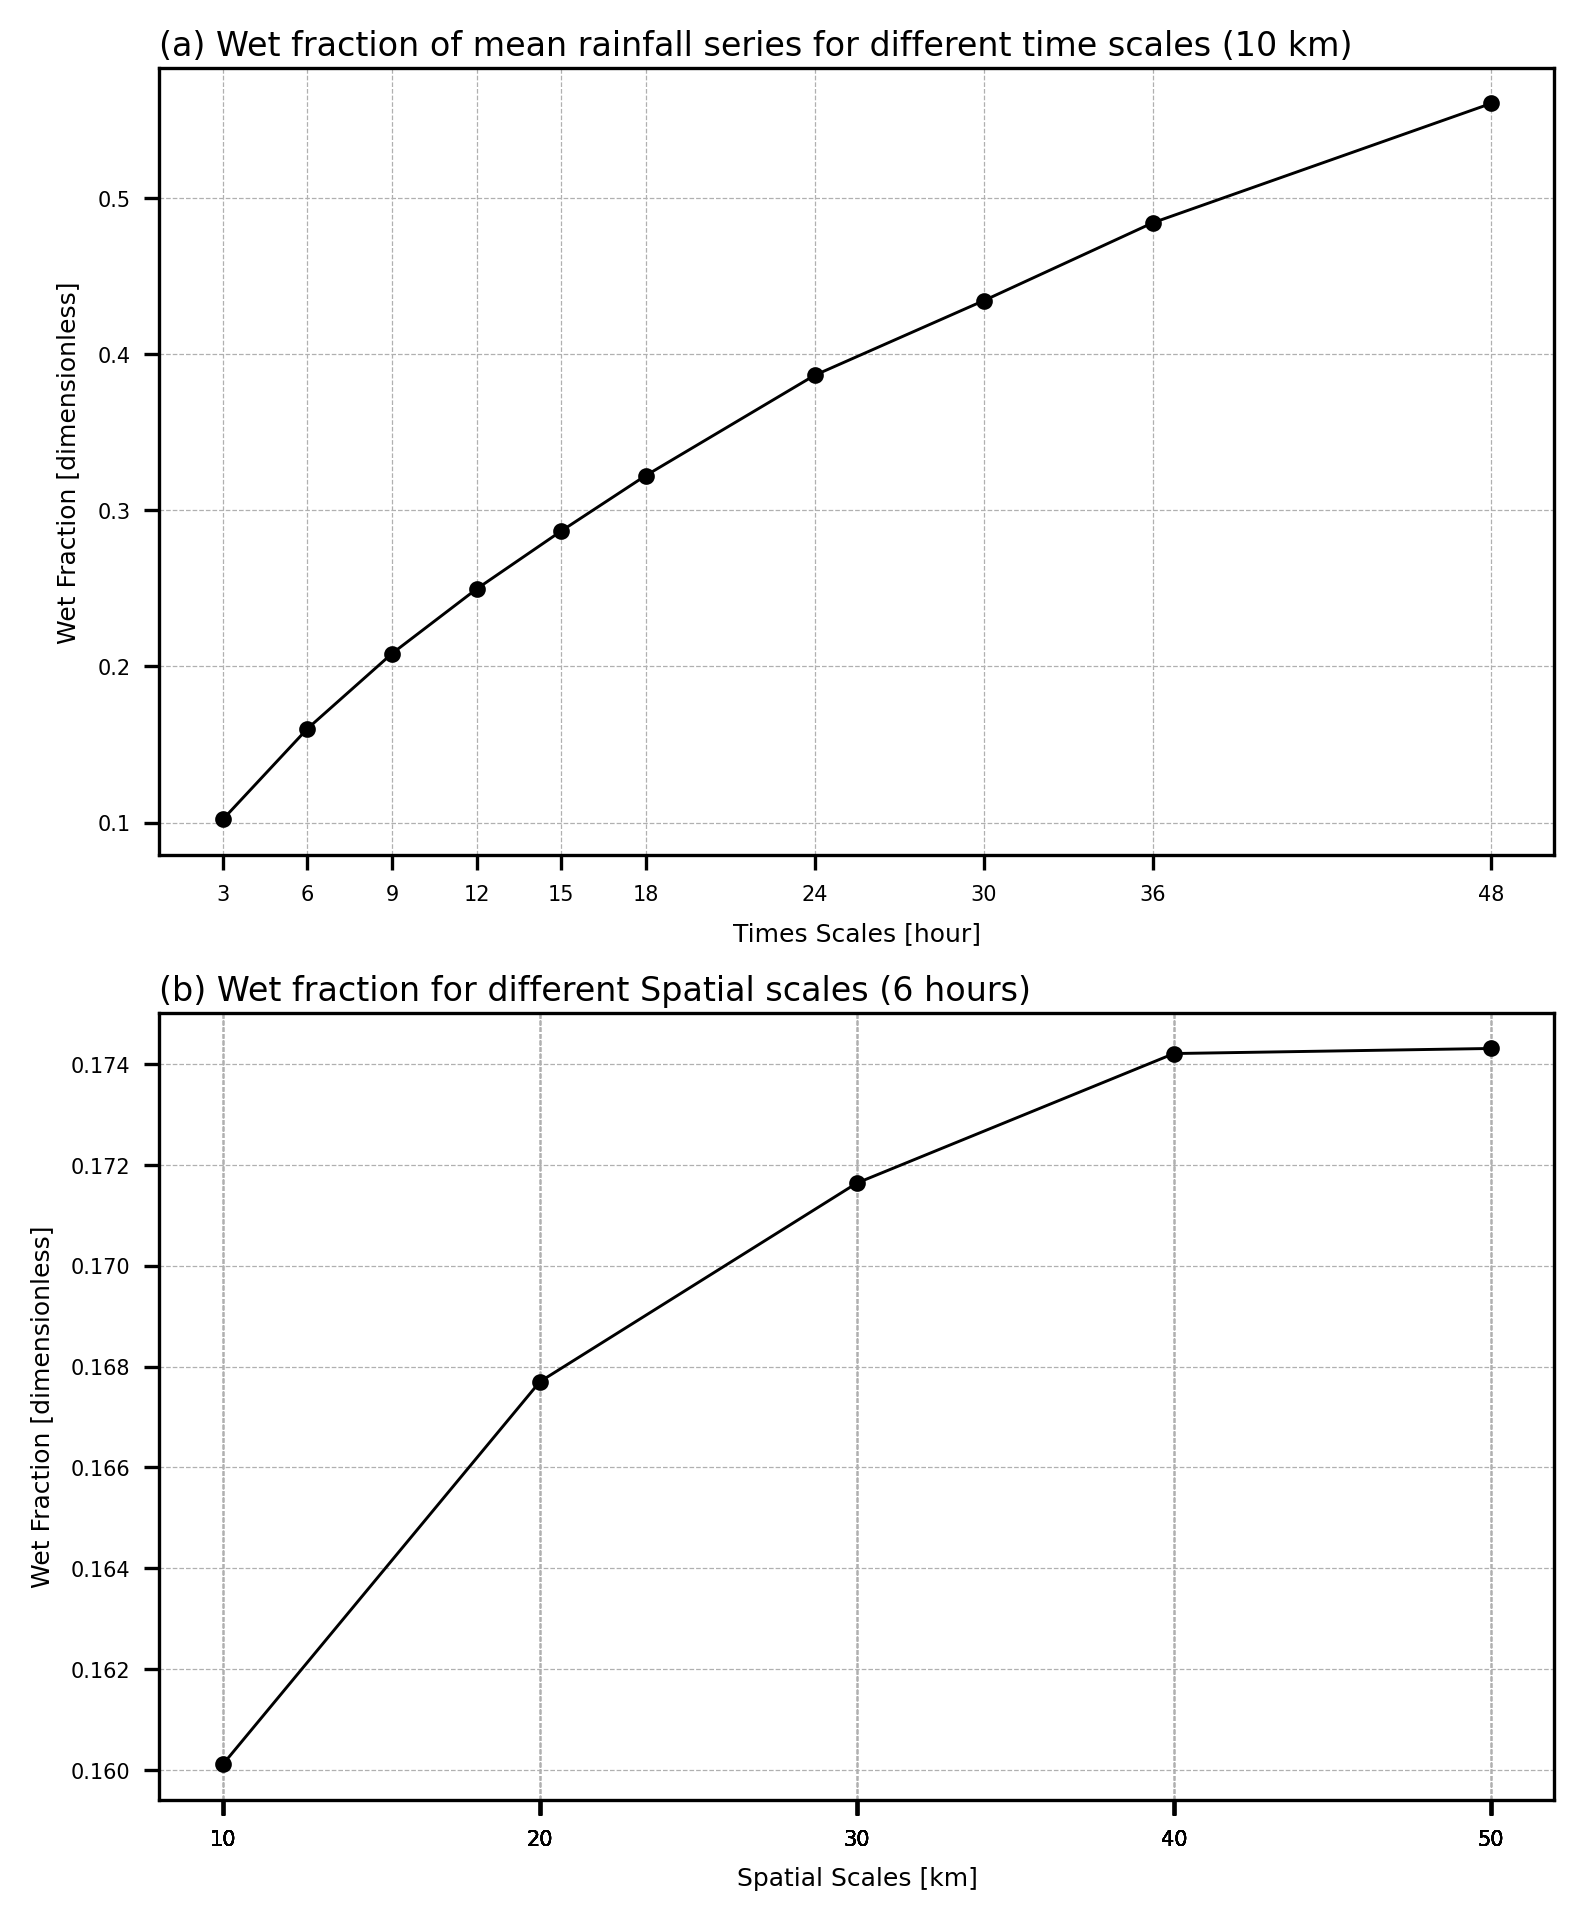

In [32]:
time_scale_pos = 0 # 3h
# time_scale_pos = 1 # 6h

fig = plt.figure(figsize=(6,7.5),dpi=300)
gs = gridspec.GridSpec(2,1)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.plot(tscales, WET_MATRIX[:,0], linewidth=0.7, c='k')
ax1.plot(tscales, WET_MATRIX[:,0], '.', c='k')

ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlabel('Times Scales [hour]', fontsize=6)
ax1.set_ylabel('Wet Fraction [dimensionless]', fontsize=6)

ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)

ax1.set_xticks(tscales)

ax1.set_title(f'(a) Wet fraction of mean rainfall series for different time scales (10 km)', loc='left', fontsize=8, pad=3)

# ============================================================================================================================
pos_ref = 1
ax1 = plt.subplot(gs[1, 0])
ax1.plot(xscales_km, WET_MATRIX[pos_ref,:], linewidth=0.7, c='k')
ax1.plot(xscales_km, WET_MATRIX[pos_ref,:], '.', c='k')

ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlabel('Spatial Scales [km]', fontsize=6)
ax1.set_ylabel('Wet Fraction [dimensionless]', fontsize=6)

ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)

ax1.set_xticks(Swet_scale)

ax1.set_title(f'(b) Wet fraction for different Spatial scales ({tscales[pos_ref]} hours)', loc='left', fontsize=8, pad=3)

# ================================================================================================
fig.patch.set_alpha(0)

# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.1, wspace=0.12)

image_dir = f'../fig/Veneto_IMERG_{name.replace(' ','_')}_{yy_s}_{yy_e}_agregation.png'
print(f'Export as: {image_dir}')
# plt.savefig(image_dir, transparent=False, bbox_inches='tight', pad_inches=0)

In [33]:
# # IMPORTANT DON'T DELETE
# # DONT USE WITH THE NEXT CODE, INDEX WITH SAMES NAMES IN BOTH CODES
# # This block create figure with the steps on Spatial Aggregation

# sx = 4
# print(f'Mean wet fraction for scale: {L1*sx} km')
# Swet_fraction = []
# x_s, x_e, y_s, y_e = [], [], [], [] 
# for i in range(nlon):
#     for j in range(nlat):
#         # # ======================================================================
#         box_tmp = box_3h[i:i+sx,j:j+sx,:] # with overlaping
#         # # ======================================================================
#         # box_tmp = box_3h[sx*i:sx*i+sx,sx*j:sx*j+sx,:] # without overlaping
#         # # ======================================================================
#         if box_tmp.shape[0] == sx and box_tmp.shape[1] == sx:
#             box_interest = box_tmp
#             # # ===========================================================================
#             # with overlaping
#             x_s.append(i)
#             x_e.append(i+sx)
#             y_s.append(j)
#             y_e.append(j+sx)
#             # # ===========================================================================
#             # # without overlaping
#             # x_s.append(sx*i)
#             # x_e.append(sx*i+sx)
#             # y_s.append(sx*j)
#             # y_e.append(sx*j+sx)
#             # # ===========================================================================
#             wet_tmp = wetfrac(box_tmp.sum(axis=(0,1)).data, thresh)
#             Swet_fraction.append(wet_tmp)
# Swet_final.append(np.mean(Swet_fraction))
# Swet_scale.append(L1*sx)

# lo_ref = np.arange(-1,7)
# la_ref = np.arange(-1,7)

# lo = np.arange(0,6)
# la = np.arange(0,6)
# matrix = np.ones([nlon, nlat])

# lo_2d, la_2d = np.meshgrid(lo, la)

# # =================================================================================================
# # =================================================================================================
# x_ref = [2, 3]
# y_ref = [2, 3]

# for nn in range(len(x_s)):
#     fig = plt.figure(figsize=(3,3),dpi=300)
#     gs = gridspec.GridSpec(1,1)

#     # ===================================================================
#     ax1 = plt.subplot(gs[0, 0])
#     ax1.pcolormesh(lo_2d, la_2d, matrix)
    
#     x_values = [x_s[nn], x_s[nn], x_e[nn], x_e[nn], x_s[nn]]
#     y_values = [y_s[nn], y_e[nn], y_e[nn], y_s[nn], y_s[nn]]
#     ax1.plot(x_values, y_values, marker='o', color='r', markersize=2)
#     ax1.fill(x_values, y_values, 'r', linewidth=0.4, alpha=0.3)
    
#     x_ref_pos = [2, 2, 3, 3, 2]
#     y_ref_pos = [2, 3, 3, 2, 2]
#     ax1.fill(x_ref_pos, y_ref_pos, c='k', linewidth=0.4, zorder=10, alpha =0.6)

#     ax1.set_xticks(lo_ref)
#     ax1.set_yticks(la_ref)
    
#     ax1.xaxis.set_tick_params(labelsize=5)
#     ax1.yaxis.set_tick_params(labelsize=5)

#     ax1.set_title(f'Spatial scale aggregation: {L1*sx} km', loc='left', fontsize=6)
#     ax1.set_title(f'[({x_s[nn]}:{x_e[nn]}),({y_s[nn]}:{y_e[nn]})]', loc='right', fontsize=6)

#     ax1.grid(linewidth=0.3, linestyle='--')

#     # ===================================================================
#     name_out = f'../fig/gif/spatial_aggregation/SA_{str(nn).zfill(2)}.png'
#     plt.savefig(name_out,transparent = False,bbox_inches ='tight',pad_inches = 0.01, facecolor=None)

In [34]:
# # IMPORTANT CODE
# DONT USE WITH THE PREVIOUS CODE, INDEX WITH SAMES NAMES IN BOTH CODES
# # AGREGGATION WITH POINT AS FOCUS
# sx = 4

# for nn in range(5):
#     if sx == 4:
#         if nn == 0:
#             x_ref = [3, 4]
#             y_ref = [3, 4]
#             x_move_s, x_move_e, y_move_s, y_move_e = -1*(sx-1), 0*(sx-1), -1*(sx-1), 0*(sx-1) #left-bottom
#         elif nn == 1:
#             x_ref = [3, 4]
#             y_ref = [1, 2]
#             x_move_s, x_move_e, y_move_s, y_move_e = -1*(sx-1), 0*(sx-1), 0*(sx-1), 1*(sx-1) #left-top
#         elif nn == 2:
#             x_ref = [1, 2]
#             y_ref = [1, 2]
#             x_move_s, x_move_e, y_move_s, y_move_e = 0*(sx-1), 1*(sx-1), 0*(sx-1), 1*(sx-1) #right-top
#         elif nn == 3:
#             x_ref = [1, 2]
#             y_ref = [3, 4]
#             x_move_s, x_move_e, y_move_s, y_move_e = 0*(sx-1), 1*(sx-1), -1*(sx-1), 0*(sx-1) #right-bottom
#     elif sx == 1:
#         x_ref = [2, 3]
#         y_ref = [2, 3]
#         x_move_s, x_move_e, y_move_s, y_move_e = 0, 0, 0, 0
#     elif sx == 5:
#         x_ref = [0, 5]
#         y_ref = [0, 5]
#         x_move_s, x_move_e, y_move_s, y_move_e = 0, 0, 0, 0
#     else:
#         x_ref = [2, 3]
#         y_ref = [2, 3]
#         if nn == 0:
#             x_move_s, x_move_e, y_move_s, y_move_e = -1*(sx-1), 0*(sx-1), -1*(sx-1), 0*(sx-1) #left-bottom
#         elif nn == 1:
#             x_move_s, x_move_e, y_move_s, y_move_e = -1*(sx-1), 0*(sx-1), 0*(sx-1), 1*(sx-1) #left-top
#         elif nn == 2:
#             x_move_s, x_move_e, y_move_s, y_move_e = 0*(sx-1), 1*(sx-1), 0*(sx-1), 1*(sx-1) #right-top
#         elif nn == 3:
#             x_move_s, x_move_e, y_move_s, y_move_e = 0*(sx-1), 1*(sx-1), -1*(sx-1), 0*(sx-1) #right-bottom


#     fig = plt.figure(figsize=(3,3),dpi=300)
#     gs = gridspec.GridSpec(1,1)

#     # ===================================================================
#     ax1 = plt.subplot(gs[0, 0])
#     ax1.pcolormesh(lo_2d, la_2d, matrix)

#     x_values = [x_ref[0]+x_move_s, x_ref[0]+x_move_s, x_ref[1]+x_move_e, x_ref[1]+x_move_e, x_ref[0]+x_move_s]
#     y_values = [y_ref[0]+y_move_s, y_ref[1]+y_move_e, y_ref[1]+y_move_e, y_ref[0]+y_move_s, y_ref[0]+y_move_s]

#     ax1.plot(x_values, y_values, marker='o', color='r', markersize=2)
#     ax1.fill(x_values, y_values, 'r', linewidth=0.4, alpha=0.3)

#     x_ref_pos = [2, 2, 3, 3, 2]
#     y_ref_pos = [2, 3, 3, 2, 2]
#     ax1.fill(x_ref_pos, y_ref_pos, c='k', linewidth=0.4, zorder=10, alpha =0.6)

#     ax1.set_xticks(lo_ref)
#     ax1.set_yticks(la_ref)

#     ax1.xaxis.set_tick_params(labelsize=5)
#     ax1.yaxis.set_tick_params(labelsize=5)

#     ax1.set_title(f'Spatial scale aggregation: {L1*sx} km', loc='left', fontsize=6)
#     ax1.set_title(f'[({x_ref[0]+x_move_s}:{x_ref[1]+x_move_e}),({y_ref[0]+y_move_s}:{y_ref[1]+y_move_e})]', loc='right', fontsize=6)

#     ax1.grid(linewidth=0.3, linestyle='--')
    
#     # ===================================================================
#     name_out = f'../fig/gif/spatial_aggregation/spatial_aggregation_{str(nn).zfill(2)}_Focus.png'
#     plt.savefig(name_out,transparent = False,bbox_inches ='tight',pad_inches = 0.01, facecolor=None)


In [35]:
xscales_km_2d, tscales_2d = np.meshgrid(xscales_km, tscales)

ntscales = np.size(tscales)
nxscales = np.size(xscales)

tscales_INTER = np.linspace(np.min(tscales), np.max(tscales), ninterp) # 2000 values between min y max de time scale
WET_MATRIX_INTER = np.zeros((ninterp, nxscales)) # 2000, 5

for col in range(nxscales):
    WET_MATRIX_INTER[:, col] = np.interp(tscales_INTER, tscales, WET_MATRIX[:, col]) # Interpolated wet fraction matrix

In [36]:
# found the wet fraction for the pixel
print(f'Spatial scale origin: {origin_x} km')
print(f'Time scale origin   : {origin_t} h')
print()

pos_xmin = np.argmin(np.abs(origin_x - xscales_km)) # original scale
pos_tmin = np.argmin(np.abs(origin_t - tscales_INTER))
pwet_origin = WET_MATRIX_INTER[pos_tmin, pos_xmin]

print(f'Position of original space scale {origin_x} km in the all scales vector is {pos_xmin}')
print(f'Position of original time scale {origin_t} hours in the all interpolated times vector is {pos_tmin}')
print()
print(f'Origin wet fraction in OLD matrix: {pwet_origin}')

Spatial scale origin: 10 km
Time scale origin   : 24 h

Position of original space scale 10 km in the all scales vector is 0
Position of original time scale 24 hours in the all interpolated times vector is 933

Origin wet fraction in OLD matrix: 0.386430730731222


In [37]:
pw_min = np.min(WET_MATRIX)
pw_max = np.max(WET_MATRIX)
mypw = np.linspace(pw_min, pw_max, ninterp)

In [38]:
myU = np.zeros(ninterp)   # initialize linear slope
myX0 = np.zeros(ninterp)  # initialize linear intercept
myindices = np.zeros((ninterp, nxscales), dtype = int)

In [39]:
for ii in range(ninterp):
    Tvec = np.zeros(nxscales)
    for jj in range(nxscales):
        myindices[ii,jj] = np.argmin(np.abs(WET_MATRIX_INTER[:, jj] - mypw[ii]))
        Tvec[jj] = tscales_INTER[myindices[ii,jj]]
    warnings.simplefilter('ignore', np.RankWarning)
    res_poly = np.polyfit(Tvec[:2], xscales_km[:2], 1)
    myU[ii] = res_poly[0]
    myX0[ii] = res_poly[1]

In [40]:
# first remove timescales where the line goes out of bounds
min_index = myindices.min(axis=1)
max_index = myindices.max(axis=1)
col_to_keep = np.logical_and(min_index > 0, max_index < ninterp-1)
mypw2 = mypw[col_to_keep]
U = myU[col_to_keep]
X0 = myX0[col_to_keep]

In [41]:
dthat = (target_x - X0) / U # compute time scale that would give me pwet
deltat = np.abs(dthat - target_t)
opt_deltat = np.min(deltat)
max_dt = 0.5 # half hour accuracy should suffice?
# set a TOLL value to check we are not too far away from the real deltat
if opt_deltat > max_dt:
    print('Taylor_Beta WARNING: not enough accuracy!')
    print('the time resolution of the coarse data might not be enough!')
    print('or try to increase the value of interp')
best_index = np.argmin(deltat)  # best prediction of 24 hour interval
pwet_target = mypw2[best_index]

print(f'Target wet fraction in OLD matrix: {pwet_target}')

Target wet fraction in OLD matrix: 0.3687177724897901


## Scipy Interpolation

In [42]:
# Define your current spatial (km), temporal (hours) scales and wet matrix
spatial_scale = np.copy(xscales_km)  # Spatial in km
temporal_scale = np.copy(tscales_INTER)  # Temporal in hours
wet_fraction_matrix =  np.copy(WET_MATRIX_INTER) # wet matrix

# Create an interpolator function, allowing extrapolation (bounds_error=False)
interpolator = RegularGridInterpolator(
    (temporal_scale, spatial_scale), wet_fraction_matrix, bounds_error=False, fill_value=None)

# New spatial scale with 100 values from 0.0001 to 50 km 
new_spatial_scale = np.linspace(0, npix*L1, 100)

# Create new grid for extrapolated data
new_spatial, new_temporal = np.meshgrid(new_spatial_scale, temporal_scale)

# Combine the spatial and temporal scales for interpolation
points_to_interpolate = np.array([new_temporal.ravel(), new_spatial.ravel()]).T

# Get the interpolated values (including extrapolated values)
new_wet_fraction_linear = interpolator(points_to_interpolate).reshape(new_temporal.shape)

In [43]:
import numpy as np
from scipy.interpolate import RBFInterpolator

# new_wet_fraction contains the values extrapolated using a cubic approach

# Define your current spatial (km), temporal (hours) scales and wet matrix
spatial_scale = np.copy(xscales_km)  # Spatial in km
temporal_scale = np.copy(tscales_INTER)  # Temporal in hours
wet_fraction_matrix = np.copy(WET_MATRIX_INTER)  # wet matrix

# Create a grid of points for the original data
original_points = np.array(np.meshgrid(temporal_scale, spatial_scale)).T.reshape(-1, 2)
wet_fraction_values = wet_fraction_matrix.ravel()

# Use RBFInterpolator for cubic extrapolation
interpolator = RBFInterpolator(original_points, wet_fraction_values, kernel='cubic')

# New spatial scale with 100 values from 0.0001 to 50 km 
new_spatial_scale = np.linspace(0.0001, npix * L1, 100)

# Create new grid for extrapolated data
new_spatial, new_temporal = np.meshgrid(new_spatial_scale, temporal_scale)

# Combine the spatial and temporal scales for interpolation
points_to_interpolate = np.array([new_temporal.ravel(), new_spatial.ravel()]).T

# Get the interpolated values (including extrapolated values)
new_wet_fraction = interpolator(points_to_interpolate).reshape(new_temporal.shape)

## Second method to interpolation

In [44]:
from scipy.interpolate import interp1d
new_xscales = np.linspace(0, 10, 100) 
interpolated_wet_fraction = np.zeros((len(tscales_INTER), len(new_xscales)))

for i in range(len(tscales_INTER)):
    # Create interpolation function for the i-th time scale (row of wet_fraction)
    f = interp1d(xscales_km, WET_MATRIX_INTER[i, :], kind='linear', fill_value="extrapolate")
    interpolated_wet_fraction[i, :] = f(new_xscales)

xscale_index_ = np.argmin(np.abs(target_x - new_xscales))
time_index_ = np.argmin(np.abs(target_t - tscales_INTER))

wet_fraction_second = interpolated_wet_fraction[time_index_, xscale_index_]

Export as: ../fig/Veneto_IMERG_Coast_Level_2001_2017_WF_OVERLAP.png


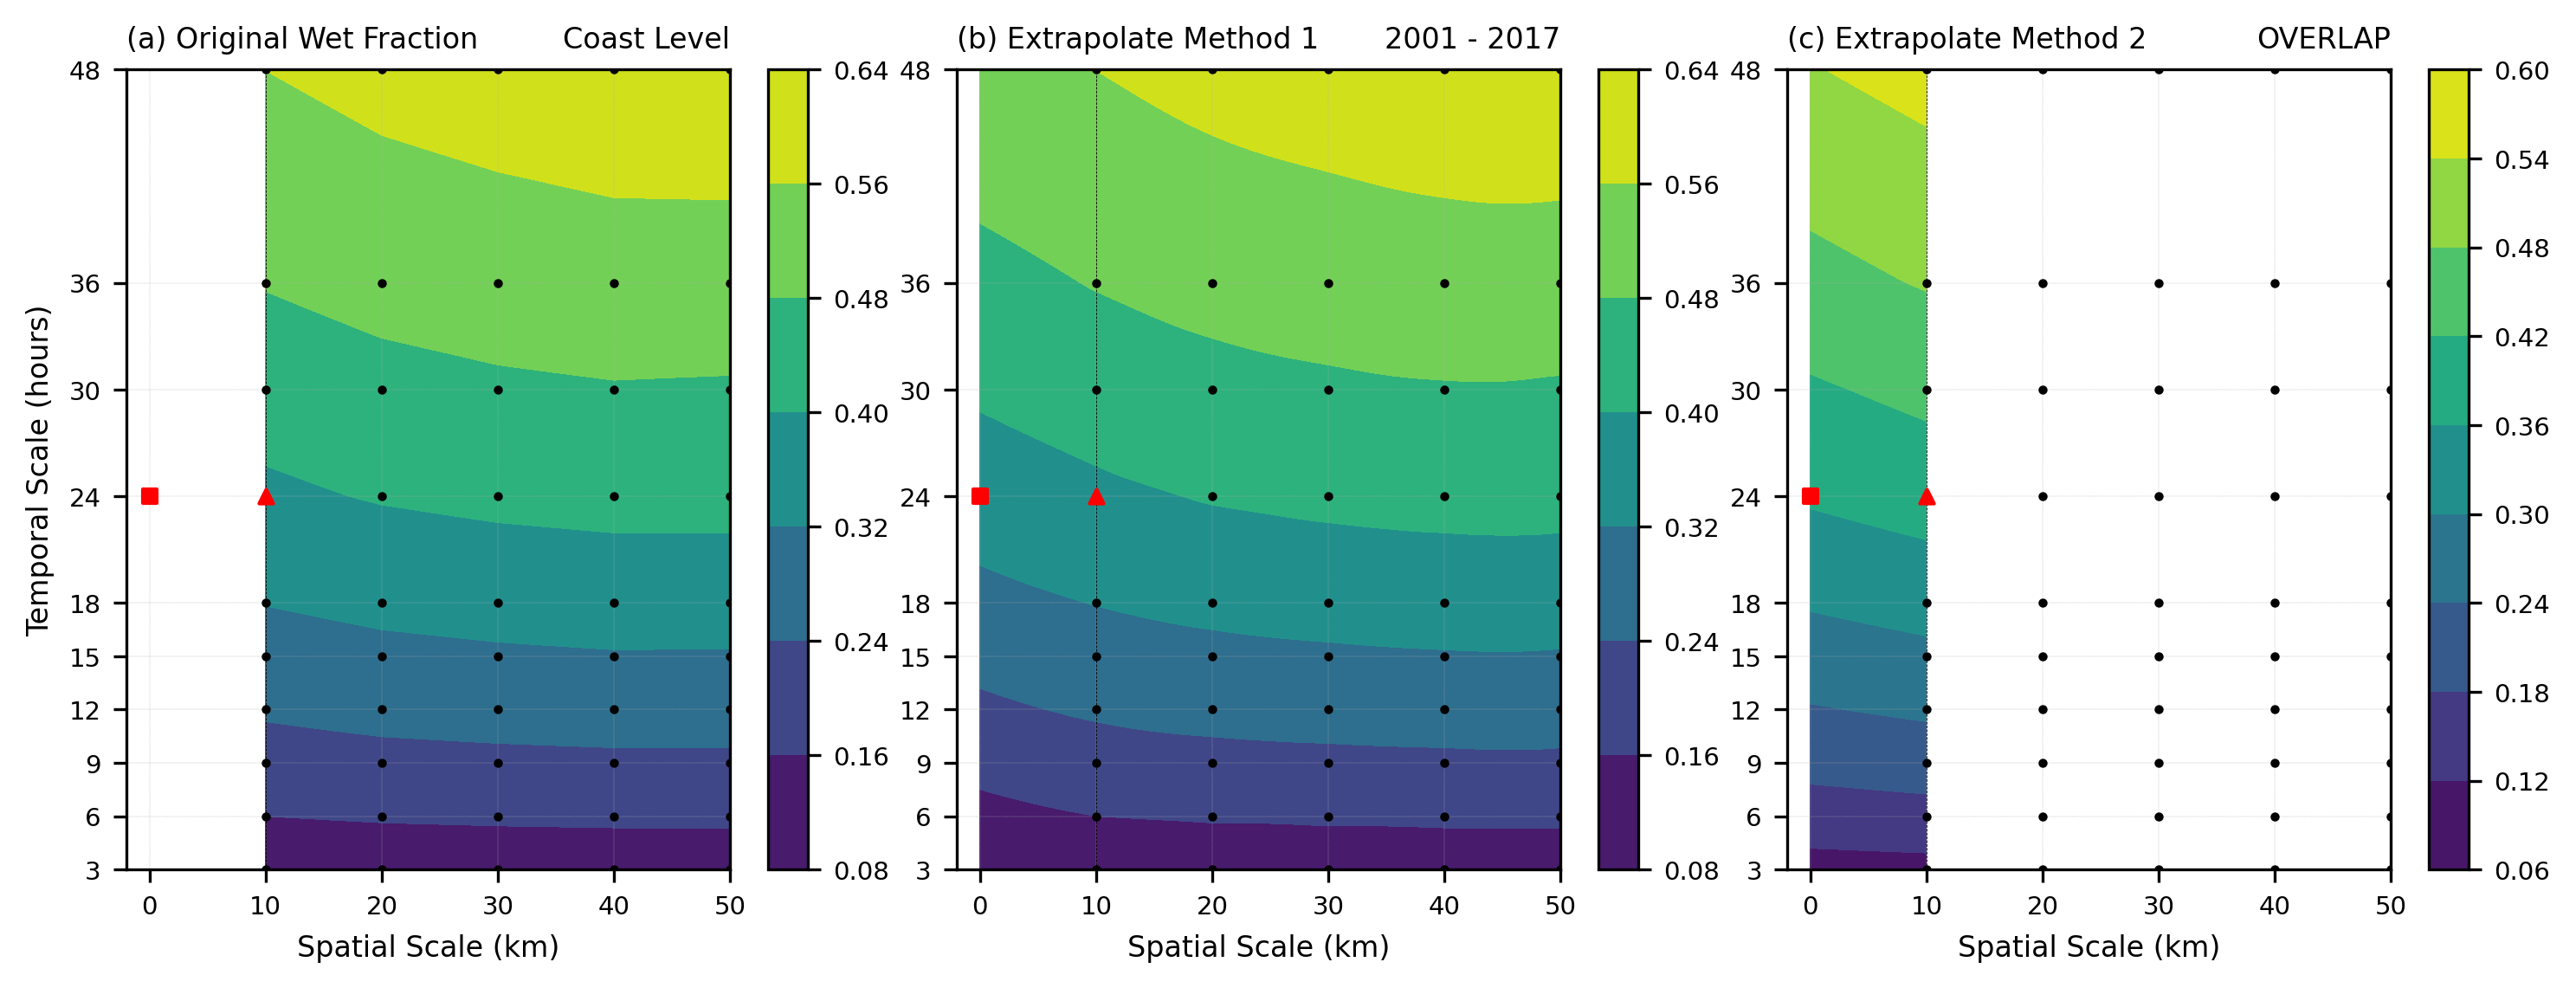

In [45]:
levels = np.arange(0,0.85,0.05)
levels = None
xxx1 = np.linspace(0, 30, 5)
xxx2 = np.linspace(30, 55, 5)

fig = plt.figure(figsize=(12,4),dpi=300)
gs = gridspec.GridSpec(1,3)

# ============================================================
ax1 = plt.subplot(gs[0, 0])
a1 = ax1.contourf(xscales_km, tscales_INTER, WET_MATRIX_INTER, cmap='viridis', levels=levels)

ax1.scatter(origin_x, origin_t, s=15, c='r', zorder=5, marker='^',label='origin')
ax1.scatter(target_x, target_t, s=15, marker='s', c='r', zorder=5, label ='target')

ax1.axvline(x=10, color='k', linestyle='--', linewidth=0.2)

ax1.plot(xscales_km_2d, tscales_2d, '.k', markersize=3)

# ax1.scatter(xxx1, (xxx1 - X0[best_index]) / U[best_index], s=2)
# ax1.plot(xxx1, (xxx1 - X0[best_index]) / U[best_index], 'b', linewidth=0.5)
# ax1.plot(xxx2, (xxx2 - X0[best_index]) / U[best_index], '--b', linewidth=0.5)

ax1.set_title('(a) Original Wet Fraction', loc='left', fontsize=8)
ax1.set_title(f'{name}',loc='right',fontsize=8)
ax1.set_xlabel('Spatial Scale (km)', fontsize=8)
ax1.set_ylabel('Temporal Scale (hours)', fontsize=8)

ax1.set_yticks(tscales)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)
ax1.grid(linewidth=0.1, linestyle='--')

cbar = plt.colorbar(a1)
cbar.ax.tick_params(labelsize=7)

ax1.set_xlim(-2,10*npix)

# ============================================================
ax1 = plt.subplot(gs[0, 1])
a1 = ax1.contourf(new_spatial_scale, temporal_scale, new_wet_fraction, cmap='viridis', levels=levels)

ax1.scatter(origin_x, origin_t, s=15, c='r', zorder=5, marker='^',label='origin')
ax1.scatter(target_x, target_t, s=15, marker='s', c='r', zorder=5, label ='target')

ax1.axvline(x=10, color='k', linestyle='--', linewidth=0.2)

ax1.plot(xscales_km_2d, tscales_2d, '.k', markersize=3)

# ax1.scatter(xxx1, (xxx1 - X0[best_index]) / U[best_index], s=2)
# ax1.plot(xxx1, (xxx1 - X0[best_index]) / U[best_index], 'b', linewidth=0.5)
# ax1.plot(xxx2, (xxx2 - X0[best_index]) / U[best_index], '--b', linewidth=0.5)

ax1.set_title('(b) Extrapolate Method 1', loc='left', fontsize=8)
ax1.set_title(f'{yy_s} - {yy_e}', loc='right', fontsize=8)
ax1.set_xlabel('Spatial Scale (km)', fontsize=8)
ax1.set_xlim(-2,10*npix)

ax1.set_yticks(tscales)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)
ax1.grid(linewidth=0.1, linestyle='--')

cbar = plt.colorbar(a1)
cbar.ax.tick_params(labelsize=7)

# ============================================================
ax1 = plt.subplot(gs[0, 2])
a1 = ax1.contourf(new_xscales, tscales_INTER, interpolated_wet_fraction, cmap='viridis', levels=levels)

ax1.scatter(origin_x, origin_t, s=15, c='r', zorder=5, marker='^',label='origin')
ax1.scatter(target_x, target_t, s=15, marker='s', c='r', zorder=5, label ='target')

ax1.axvline(x=10, color='k', linestyle='--', linewidth=0.2)

ax1.plot(xscales_km_2d, tscales_2d, '.k', markersize=3)

# ax1.scatter(xxx1, (xxx1 - X0[best_index]) / U[best_index], s=2)
# ax1.plot(xxx1, (xxx1 - X0[best_index]) / U[best_index], 'b', linewidth=0.5)
# ax1.plot(xxx2, (xxx2 - X0[best_index]) / U[best_index], '--b', linewidth=0.5)

ax1.set_title('(c) Extrapolate Method 2', loc='left', fontsize=8)
ax1.set_title(f'{fig_val}', loc='right', fontsize=8)
ax1.set_xlabel('Spatial Scale (km)', fontsize=8)

ax1.set_yticks(tscales)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)
ax1.grid(linewidth=0.1, linestyle='--')

cbar = plt.colorbar(a1)
cbar.ax.tick_params(labelsize=7)

ax1.set_xlim(-2,10*npix)

# ================================================================================================
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.1, wspace=0.1)

image_dir = f'../fig/Veneto_IMERG_{name.replace(' ','_')}_{yy_s}_{yy_e}_WF_{fig_val}.png'
print(f'Export as: {image_dir}')
# plt.savefig(image_dir,transparent = False,bbox_inches ='tight',pad_inches = 0, facecolor=None)

In [46]:
def obtain_points(WET_input, tscale, Scale_column):

    xscales_km = [10, 20, 30, 40, 50]
    
    points_ref = np.where((tscale>15)&(tscale<24))[0]
    WET_ref = np.round(WET_input[points_ref,Scale_column],2)
    DICT = pd.DataFrame({'points':points_ref, 'WET':WET_ref})

    dif = []
    for nn in range(len(WET_ref)-1):
        dif.append((WET_ref[nn+1]-WET_ref[nn])**2)

    positions = np.where(dif == np.max(dif))[0]

    extracted_df = DICT.iloc[positions]
    pos_clear = extracted_df['points'].values

    pp_tmp = tscales_INTER[pos_clear]

    pos_tmp = np.ones(len(pp_tmp)) * xscales_km[Scale_column]

    return pos_tmp, pp_tmp

In [47]:
test_10 = obtain_points(WET_MATRIX_INTER, tscales_INTER, 0)
test_20 = obtain_points(WET_MATRIX_INTER, tscales_INTER, 1)

In [48]:
import numpy as np

# Given known points (time, space) and corresponding wet fraction values
points = np.array([[21.05402701350675, 10],  # (time, space)
                    [19.455727863931966, 20]]) # (time, space)

wet_fractions = np.array([0.3548404183359204, 0.3548786268090165])

# Target point: (time = 24, space = 0.0001)
target_point = np.array([24, 0.0001])

# Fit a linear model: Wet Fraction = a * time + b * space + c
A = np.hstack([points, np.ones((points.shape[0], 1))])  # Add bias column for c
coefficients = np.linalg.lstsq(A, wet_fractions, rcond=None)[0]

a, b, c = coefficients

# Predict wet fraction for the target point (24, 0.0001)
target_wet_fraction = a * target_point[0] + b * target_point[1] + c

print(f"Predicted wet fraction at time = {target_point[0]} hours and space = {target_point[1]} km is: {target_wet_fraction}")


Predicted wet fraction at time = 24.0 hours and space = 0.0001 km is: 0.3758689001703521


(-2.0, 50.0)

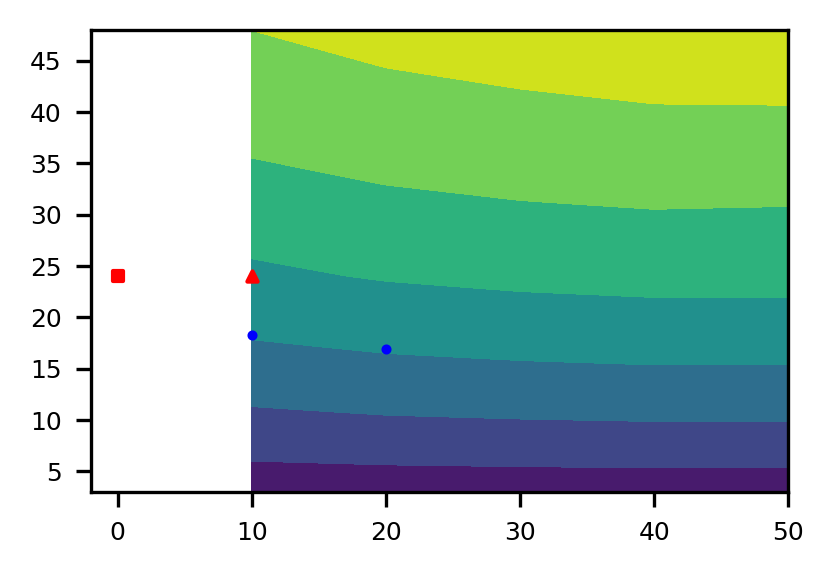

In [49]:
xxx1 = np.linspace(0, 30, 5)
xxx2 = np.linspace(30, 55, 5)

fig = plt.figure(figsize=(3,2),dpi=300)
gs = gridspec.GridSpec(1,1)

# ============================================================
ax1 = plt.subplot(gs[0, 0])

# ax1.scatter(test_10[0], test_10[1], s=0.4, c='k', zorder=10)
# ax1.scatter(test_20[0], test_20[1], s=0.4, c='k', zorder=10)

ax1.scatter(test_10[0][3], test_10[1][3], s=2, c='b', zorder=10)
ax1.scatter(test_20[0][2], test_20[1][2], s=2, c='b', zorder=10)

a1 = ax1.contourf(xscales_km, tscales_INTER, WET_MATRIX_INTER, cmap='viridis', levels=levels)

ax1.scatter(origin_x, origin_t, s=6, c='r', zorder=5, marker='^',label='origin')
ax1.scatter(target_x, target_t, s=6, marker='s', c='r', zorder=5, label ='target')

ax1.xaxis.set_tick_params(labelsize=6)
ax1.yaxis.set_tick_params(labelsize=6)

ax1.set_xlim(-2,L1*npix)

In [50]:
pos_xmin = np.argmin(np.abs(origin_x - new_spatial_scale))
pos_tmin = np.argmin(np.abs(origin_t - tscales_INTER))
pwet_origin_new = new_wet_fraction[pos_tmin, pos_xmin]

print(f'Origin wet fraction in OLD matrix: {pwet_origin}')
print(f'Origin wet fraction in NEW matrix: {pwet_origin_new}')
print()

pos_xmin = np.argmin(np.abs(target_x - new_spatial_scale))
pos_tmin = np.argmin(np.abs(target_t - tscales_INTER))
pwet_target_new = new_wet_fraction[pos_tmin, pos_xmin]

print(f'Target wet fraction in OLD matrix : {pwet_target}')
print(f'Target wet fraction in NEW1 matrix: {pwet_target_new}')
print(f'Target wet fraction in NEW2 matrix: {wet_fraction_second}')
print()

beta_old = pwet_origin / pwet_target
beta_new1 = pwet_origin_new / pwet_target_new
beta_new2 = pwet_origin_new / pwet_target_new

print(f'Beta original (Zorzeto)   : {beta_old}')
print(f'Beta extrapolate all      : {beta_new1}')
print(f'Beta extrapolate only left: {beta_new2}')
print()

# res['beta'] = beta_old
res['beta'] = beta_new1
# res['beta'] = 1.09 #manual
print(f'Beta for downscalling: {res['beta']}')

Origin wet fraction in OLD matrix: 0.386430730731222
Origin wet fraction in NEW matrix: 0.3865982764523357

Target wet fraction in OLD matrix : 0.3687177724897901
Target wet fraction in NEW1 matrix: 0.358429311084122
Target wet fraction in NEW2 matrix: 0.3673465288009473

Beta original (Zorzeto)   : 1.0480393394704683
Beta extrapolate all      : 1.0785900162099258
Beta extrapolate only left: 1.0785900162099258

Beta for downscalling: 1.0785900162099258


## Continue with Downscaling Process

In [51]:
parnames = ['eps', 'alp'] if acf == 'mar' else ['d0', 'mu0']

## Correlation between each couple of grid cells

In [52]:
lats = xdaily.dropna(dim='time', how='any').lat.values
lons = xdaily.dropna(dim='time', how='any').lon.values
nlats = np.size(lats)
nlons = np.size(lons)
nelem = nlats*nlons
lats9 = np.repeat(lats, nlons)
lons9 = np.tile(lons, nlats)

In [53]:
ncorr = (nelem)*(nelem - 1)//2
vdist = np.zeros(ncorr)
count = 0

vcorr_spearman = np.zeros(ncorr)

for i in range(nelem):
    # print(f'Point 1: {i}')
    tsi = xdaily.dropna(dim='time', how='any').loc[dict(lat=lats9[i], lon=lons9[i])].values
    tsi = np.maximum(tsi, 0.0) # Values less or equal than 0.0 is replaced with 0
    for j in range(i+1, nelem):
        # print(f'  Point 2: {j}')
        tsj = xdaily.dropna(dim='time', how='any').loc[dict(lat=lats9[j], lon=lons9[j])].values
        tsj = np.maximum(tsj, 0.0)
        vdist[count] = down.haversine(lats9[i], lats9[j], lons9[i], lons9[j])
        vcorr_spearman[count], _ = spearmanr(tsi, tsj) #Spearman Correlation
        count = count + 1

res['vdist'] = vdist
res['vcorr'] = vcorr_spearman

xx = np.linspace(np.min(vdist), np.max(vdist), 40)

popt, pcov = down.curve_fit(down.str_exp_fun, vdist, vcorr_spearman, p0=np.array([50, 1]),
                bounds=(np.array([0.0, 0.0]), np.array([+np.inf, +np.inf])))
res['d0_s'] = popt[0]
res['mu0_s'] = popt[1]

popt1, pcov1 = down.curve_fit(down.epl_fun, vdist, vcorr_spearman, p0=np.array([50, 1]),
                bounds=(np.array([0.0, 0.0]), np.array([+np.inf, +np.inf])))
res['eps_s'] = popt1[0]
res['alp_s'] = popt1[1]

In [54]:
# cmap = plt.cm.Spectral_r
# proj = ccrs.PlateCarree()
# count = 0
# for n in range(nelem):#nelem
#     for m in range(nelem):
#         fig = plt.figure(figsize=(5,5),dpi=300)
#         gs = gridspec.GridSpec(2,2)

#         # ============================================================================================================================
#         ax1 = plt.subplot(gs[0, 0], projection = proj)
#         ax1.set_extent([10.5, 13.2, 44.7, 46.8], crs=proj)
#         ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
#         ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.6, alpha=0.5)

#         for n0 in range(nelem):
#             ax1.text(lons9[n0], lats9[n0], '.', fontsize=4, color='black', ha='center', va='center')

#         ax1.text(lons9[n], lats9[n], str(n), fontsize=4, color='blue', ha='center', va='center') 

#         ax1.set_title('(a) First Pixel (P1)', loc='left', fontsize=8)

#         # ============================================================================================================================
#         ax1 = plt.subplot(gs[0, 1], projection = proj)
#         ax1.set_extent([10.5, 13.2, 44.7, 46.8], crs=proj)
#         ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
#         ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.6, alpha=0.5)

#         for n1 in range(nelem):
#             if n1 == m:
#                 continue
#             else:
#                 ax1.text(lons9[n1], lats9[n1], '.', fontsize=4, color='black', ha='center', va='center')
                
#         plt.text(lons9[m], lats9[m], str(m), fontsize=4, color='r', ha='center', va='center')
        
#         # for m1 in range(m+1):
#         #     if m1 == 0:
#         #         plt.text(lons9[0], lats9[0], str(0), fontsize=4, color='r', ha='center', va='center')
#         #     else:
#         #         plt.text(lons9[m1], lats9[m1], str(m1), fontsize=4, color='r', ha='center', va='center')
        
#         ax1.set_title('(b) Second Pixel (P2)', loc='left', fontsize=8)

#         # ============================================================================================================================
#         ax1 = plt.subplot(gs[1, 0:])
#         ax1.scatter(vdist[0:count], vcorr_spearman[0:count], s=5, marker='.')
#         ax1.set_ylim(0.6,1)
#         ax1.set_xlim(7, 60)

#         ax1.xaxis.set_tick_params(labelsize=6)
#         ax1.yaxis.set_tick_params(labelsize=6)
        
#         ax1.set_title('(c) Spearman Correlation between P1 and P2', loc='left', fontsize=8)
#         ax1.set_xlabel('Distance [km]', fontsize=6)
#         ax1.set_ylabel('Spearman Correlation', fontsize=6)
        
#         # if n == 1 and m == nelem -1:
#         #     ax1.plot(xx, down.str_exp_fun(xx, res['d0_s'], res['mu0_s']), 'r',label='Stretched Exp.')
#         #     ax1.plot(xx, down.epl_fun(xx, res['eps_s'], res['alp_s']), 'g',label='Exp. Power Law')
#         #     plt.legend(fontsize=6)

#         # ============================================================================================================================
#         plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.1, wspace=0.1)
#         count = count +1
#         image_dir = f'../fig/corr/Corr_{str(count).zfill(3)}.png'
#         plt.savefig(image_dir,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)
        
#         plt.close(fig)

# print(f'The figures was export to: ../fig/corr/')

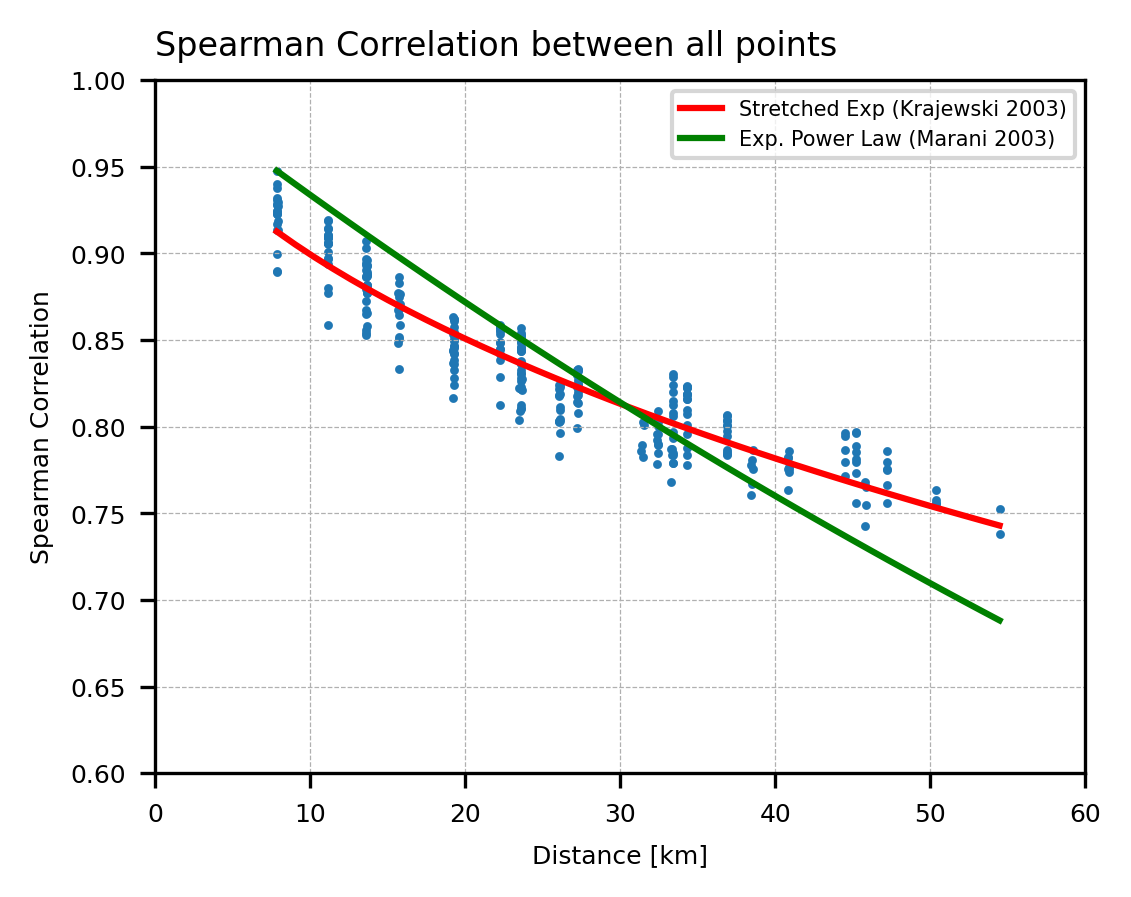

In [55]:
fig = plt.figure(figsize=(4,3),dpi=300)
gs = gridspec.GridSpec(1,1)

ax1 = plt.subplot(gs[0, 0])
ax1.scatter(res['vdist'], res['vcorr'], s=5, marker='.')
ax1.set_ylim(0.6,1)
ax1.set_xlim(7, 60)

ax1.xaxis.set_tick_params(labelsize=6)
ax1.yaxis.set_tick_params(labelsize=6)

ax1.set_title('Spearman Correlation between all points', loc='left', fontsize=8)
ax1.set_xlabel('Distance [km]', fontsize=6)
ax1.set_ylabel('Spearman Correlation', fontsize=6)

ax1.plot(xx, down.str_exp_fun(xx, res['d0_s'], res['mu0_s']), 'r',label='Stretched Exp (Krajewski 2003)')
ax1.plot(xx, down.epl_fun(xx, res['eps_s'], res['alp_s']), 'g',label='Exp. Power Law (Marani 2003)')

ax1.set_xlim(0,60)

ax1.grid(linewidth=0.3, linestyle='--')
plt.legend(fontsize=5)

## Downscale the correlation function obtained from spatial averages (bin_ave_corr)

In [56]:
# compute block averages to approximate the empirical correlation function
vd = np.sort(res['vdist']) # order distance
cd = vcorr_spearman[np.argsort(res['vdist'])] # order correlation in relation to distance
m = np.size(vd) # number of distance (300)
toll_cluster = 1

res['vd'] = vd
res['cd'] = cd

In [57]:
cluster = np.zeros(m)
count = 0
for i in range(1, m):
    if np.abs(vd[i]-vd[i-1]) < toll_cluster:
        cluster[i] = count
    else:
        count = count + 1
        cluster[i] = count

In [58]:
clust = set(cluster) # Extract only the uniques values
nclust = len(clust) # Numero de grupos

print(f'Number of clusters: {nclust}')

vdist_ave = np.zeros(nclust)
vcorr_ave = np.zeros(nclust)

for ei, elem in enumerate(clust):
    di = vd[cluster==elem] # Distance
    ci = cd[cluster==elem] # Correlation
    vdist_ave[ei] = np.mean(di) # Mean Distance
    vcorr_ave[ei] = np.mean(ci) # Mean Correlation

res['vdist_ave'] = vdist_ave
res['vcorr_ave'] = vcorr_ave
res['cluster']  = cluster

Number of clusters: 17


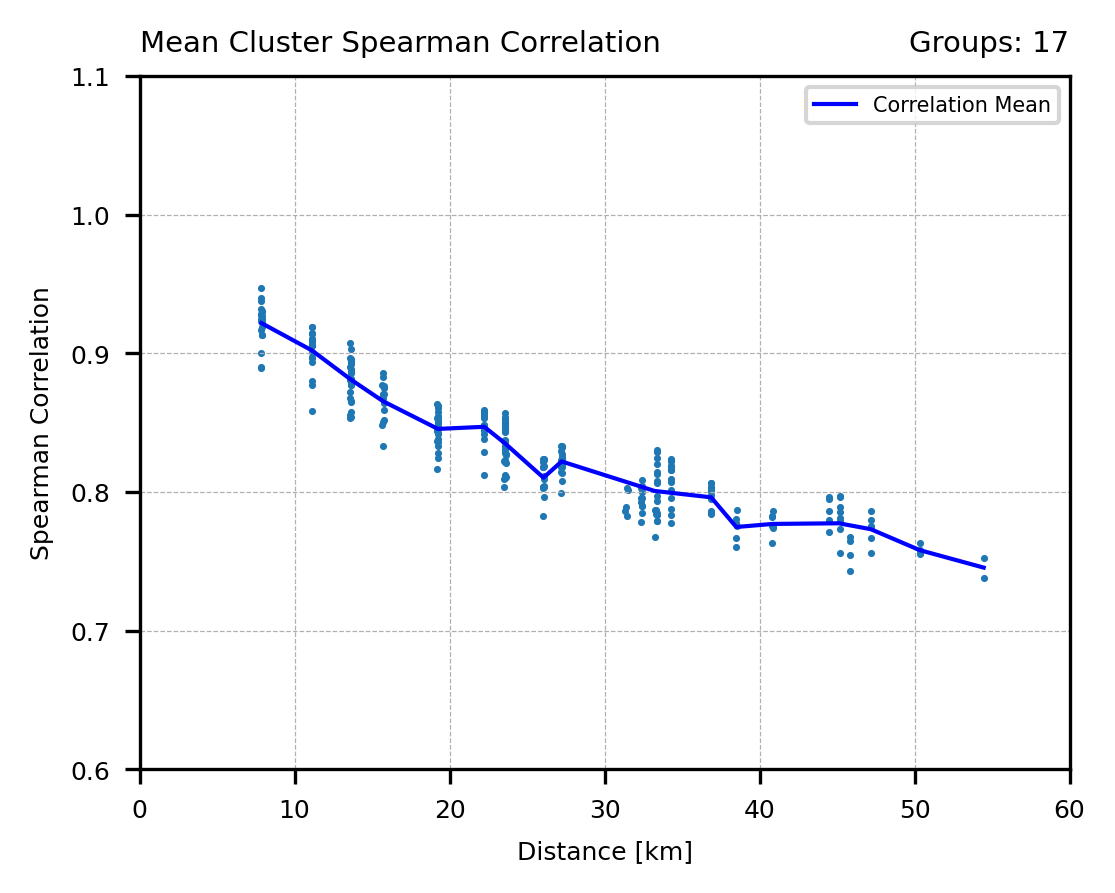

In [59]:
fig = plt.figure(figsize=(4,3),dpi=300)
gs = gridspec.GridSpec(1,1)

ax1 = plt.subplot(gs[0, 0])
ax1.scatter(res['vdist'], res['vcorr'], s=2, marker='.')
ax1.plot(vdist_ave, vcorr_ave, '-b', linewidth=1, label='Correlation Mean')

ax1.xaxis.set_tick_params(labelsize=6)
ax1.yaxis.set_tick_params(labelsize=6)

ax1.set_title('Mean Cluster Spearman Correlation', loc='left', fontsize=7)
ax1.set_title(f'Groups: {nclust}', loc='right', fontsize=7)

ax1.set_xlabel('Distance [km]', fontsize=6)
ax1.set_ylabel('Spearman Correlation', fontsize=6)

ax1.set_xlim(0,60)
ax1.set_ylim([0.6, 1.1])

ax1.grid(linewidth=0.3, linestyle='--')
plt.legend(fontsize=5)

## Downscale the correlation function obtained from spatial averages

In [60]:
# from scipy.integrate import dblquad, nquad

# def epl_fun(x, epsilon, alpha):
#     '''
#     Marco's Exponential kernel + Power law tail
#     (autocorrelation) function with exponential nucleus and power law decay
#     for x> epsilon - 2 parameters
#     see Marani 2003 WRR for more details
#     '''
#     x = np.asarray(x) # transform to numpy array
#     is_scalar = False if x.ndim > 0 else True # create flag for output
#     x.shape = (1,)*(1-x.ndim) + x.shape # give it dimension 1 if scalar
#     m = np.size(x)
#     myfun = np.zeros(m)
#     for ii in range(m):
#         if x[ii] < 10e-6:
#             myfun[ii] = 1
#         elif x[ii] < epsilon:
#             myfun[ii] = np.exp(-alpha*x[ii]/epsilon)
#         else:
#             # silence it if negative parameters -
#             # with warnings.simplefilter('ignore', RuntimeWarning):
#             myfun[ii] = (epsilon/np.exp(1)/x[ii])**alpha
#             # print('epsilon = ', epsilon)
#             # if epsilon < 1e-5 or alpha < 1e-5:
#             #     print('epsilon = ', epsilon)
#             #     print('alpha =', alpha)
#             # else:
#     myfun = myfun if not is_scalar else myfun[0]
#     return  myfun

# def nabla_2d(par_acf, myacf, T1, T2, err_min = 1e-2):
#     '''########################################################################
#     Compute the variance function as in Vanmarcke's book.
#     INPUTS::
#         par_acf = tuple with the parameters of the autocorr function (ACF)
#         myacf = ACF in 1,2,or 3 dimensions, with parameters in par_acf
#         T1 = 1st dimension of averaging area
#         T2 = 2nd dim of the averaging area'''
#     if (T1 == 0) or (T2 == 0):
#         print('integration domain is zero')
#         return 0.0 # integral is zero in this case.
#     else:
#         fun_XY = lambda x ,y: (T1 - x ) *(T2 - y ) *myacf(x ,y, par_acf)
#         myint, myerr = nquad(fun_XY, [[0. ,T1], [0. ,T2]])
#         # if myint != 0.0:
#         #     rel_err = myerr /myint
#         # else:
#         #     rel_err = 0
#         # if rel_err > err_min:
#         #     print('varfun ERROR --> Numeric Integration scheme does not converge')
#         #     print('int rel error = ', rel_err)
#         #     sys.exit("aargh! there are errors!") # to stop code execution
#         return 4.0 * myint

# def fast_corla_2d(par_acf, myacf, Tx, L, err_min=1e-2):
#     nab_1 = nabla_2d(par_acf, myacf, L, Tx[0], err_min=err_min)
#     nab_2 = nabla_2d(par_acf, myacf, L, Tx[1], err_min=err_min)
#     nab_3 = nabla_2d(par_acf, myacf, L, Tx[2], err_min=err_min)
#     nab_den = nabla_2d(par_acf, myacf, L, L, err_min=err_min)
#     if np.abs(nab_den) < 10e-6: # to avoid infinities
#         # print('correcting - inf value')
#         nab_den = 10e-6
#     covla = 2*(nab_1 -2*nab_2 + nab_3)/(4*nab_den)
#     # print('parhat =', par_acf)
#     return covla

# def myfun_sse(xx, yobs, parhat, L, acf = 'mar'):
#     xx = np.asarray(xx)
#     myacf = lambda x, y, parhat: myacf_2d(x, y, parhat, acf=acf)
#     # Ty = np.array([L, 0., L, 0.])
#     sse = 0
#     m = np.size(xx)
#     for ii in range(m):
#         myx = xx[ii]
#         Tx = np.array([np.abs(L - myx), myx, L + myx, myx])
#         # L2 = [L, L]
#         # res_ = corla_2d(L2, L2, parhat, myacf, Tx, Ty, err_min=1e-5)
#         # faster option: - same result (optimized)
#         res_ = fast_corla_2d(parhat, myacf, Tx, L, err_min=1e-2)
#         sse = sse + (res_ - yobs[ii]) ** 2
#         # sse = sse + ((res_ - yobs[ii])/yobs[ii]) ** 2 # norm
#     # print('sse', sse)
#     # print('parhat =', parhat)
#     return sse

## use_ave = 'True'

Text(0, 0.5, 'Spearman Correlation')

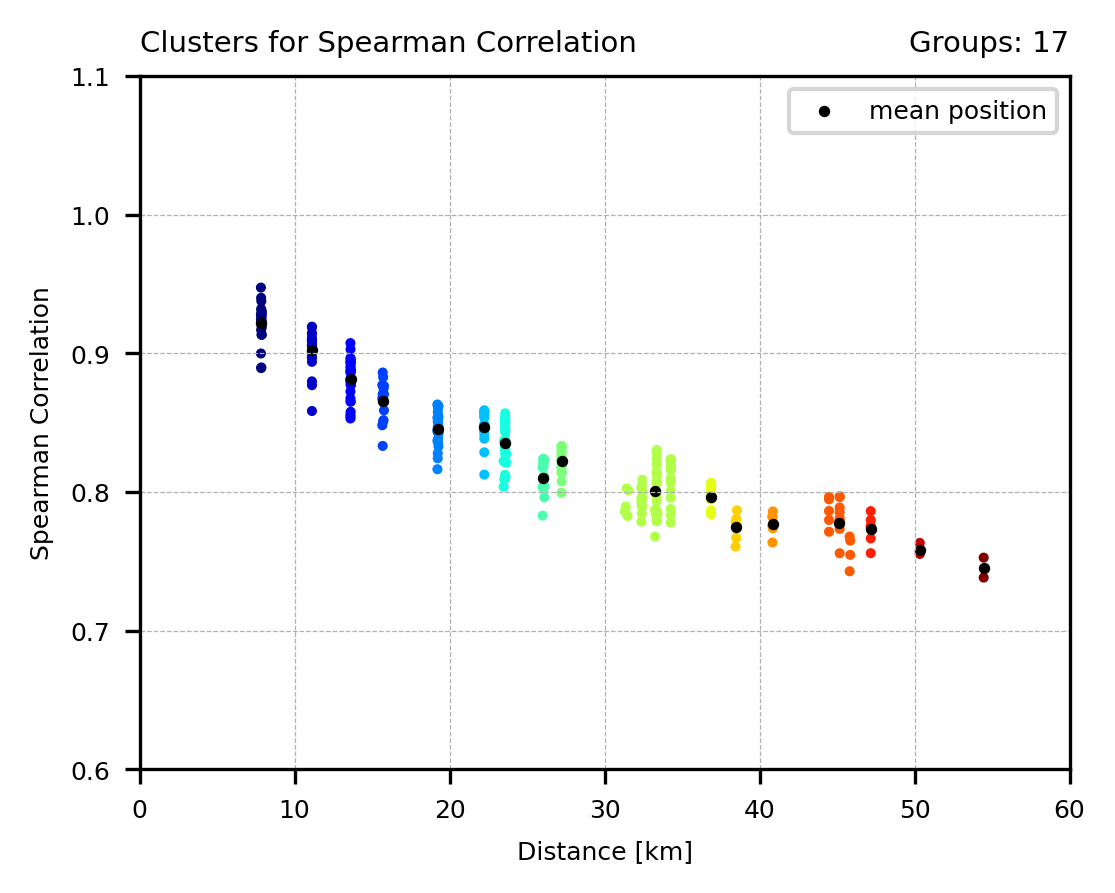

In [61]:
fig = plt.figure(figsize=(4,3),dpi=300)
gs = gridspec.GridSpec(1,1)

ax1 = plt.subplot(gs[0, 0])
ax1.scatter(vd, cd, s=2, c=cluster, cmap='jet') # Sorted for cluste has same color
ax1.scatter(res['vdist_ave'], res['vcorr_ave'], s=3, c='k', label='mean position')

ax1.grid(linewidth=0.3, linestyle='--')
ax1.legend(fontsize = 6)

ax1.xaxis.set_tick_params(labelsize=6)
ax1.yaxis.set_tick_params(labelsize=6)

ax1.set_xlim(0,60)
ax1.set_ylim([0.6, 1.1])

ax1.set_title('Clusters for Spearman Correlation', loc='left', fontsize=7)
ax1.set_title(f'Groups: {nclust}', loc='right', fontsize=7)
ax1.set_xlabel('Distance [km]', fontsize=6)
ax1.set_ylabel('Spearman Correlation', fontsize=6)

In [62]:
parnames = ['eps_d', 'alp_d'] if acf == 'mar' else ['d0_d', 'mu0_d']
print(f'parnames: {parnames}')

parnames: ['d0_d', 'mu0_d']


## Down_corr()
### opt_method == 'genetic'

In [188]:
bounds = [(0.0, 200.0),(0, 1)]  #default 200.0 and 1.0

### differential_evolution:
La función differential_evolution de scipy.optimize es un algoritmo de optimización evolutiva que se utiliza para resolver problemas de optimización global. Esta técnica pertenece a la familia de los algoritmos evolutivos y es útil para encontrar el mínimo global de funciones con múltiples variables, especialmente cuando las funciones son no lineales, no derivables o tienen múltiples óptimos locales.

In [189]:
# Functions order
# myfun_sse --> myacf_2d
use_ave=True
if not use_ave:
    print('Dont using Average')
    def myfun(pardown):
        return down.myfun_sse(res['vdist'], res['vcorr'], pardown, L1, acf=acf)
else:
    print('Using Average') # faster and more stable numerically
    def myfun(pardown):
        return down.myfun_sse(res['vdist_ave'], res['vcorr_ave'], pardown, L1, acf=acf)

Using Average


In [190]:
from scipy.optimize import differential_evolution
resmin = differential_evolution(myfun, bounds, disp=True, tol = toll, atol = toll)

differential_evolution step 1: f(x)= 0.0015803407080490362
differential_evolution step 2: f(x)= 0.0015803407080490362
differential_evolution step 3: f(x)= 0.0015803407080490362
differential_evolution step 4: f(x)= 0.0015803407080490362
differential_evolution step 5: f(x)= 0.0015347149731997774
differential_evolution step 6: f(x)= 0.0015347149731997774
differential_evolution step 7: f(x)= 0.0015347149731997774
differential_evolution step 8: f(x)= 0.001189001600211319
differential_evolution step 9: f(x)= 0.001189001600211319
differential_evolution step 10: f(x)= 0.001189001600211319
differential_evolution step 11: f(x)= 0.001189001600211319
Polishing solution with 'L-BFGS-B'


In [195]:
res[parnames[0]] = resmin.x[0]
res[parnames[1]] = resmin.x[1]
res['success'] = resmin.success
res['funval'] = resmin.fun
print(f'Optimal values: {resmin.x[0]} and {resmin.x[1]}')

Optimal values: 14.590541177041702 and 0.11459425649887495


In [196]:
if acf == 'mar':
    par_acf = (res['eps_d'], res['alp_d'])
elif acf == 'str':
    par_acf = (res['d0_d'], res['mu0_d'])

print(f'Optimal values : {par_acf}')
print(f'Parameters used: {parnames}')

Optimal values : (14.590541177041702, 0.11459425649887495)
Parameters used: ['d0_d', 'mu0_d']


### int_corr() function

In [197]:
xx = np.linspace(0.0, 60)
m = np.size(xx)
corrL = np.zeros(m)
for i in range(m):
    Tx = np.array([np.abs(L1-xx[i]), xx[i], L1+xx[i], xx[i]]) # L1-xx, xx, L1+xx, xx
    myacf = lambda x, y, parhat: down.myacf_2d(x, y, par_acf, acf=acf)
    corrL[i] = down.fast_corla_2d(par_acf, myacf, Tx, L1, err_min=1e-2)

integration domain is zero


Text(0, 0.5, 'correlation [-]')

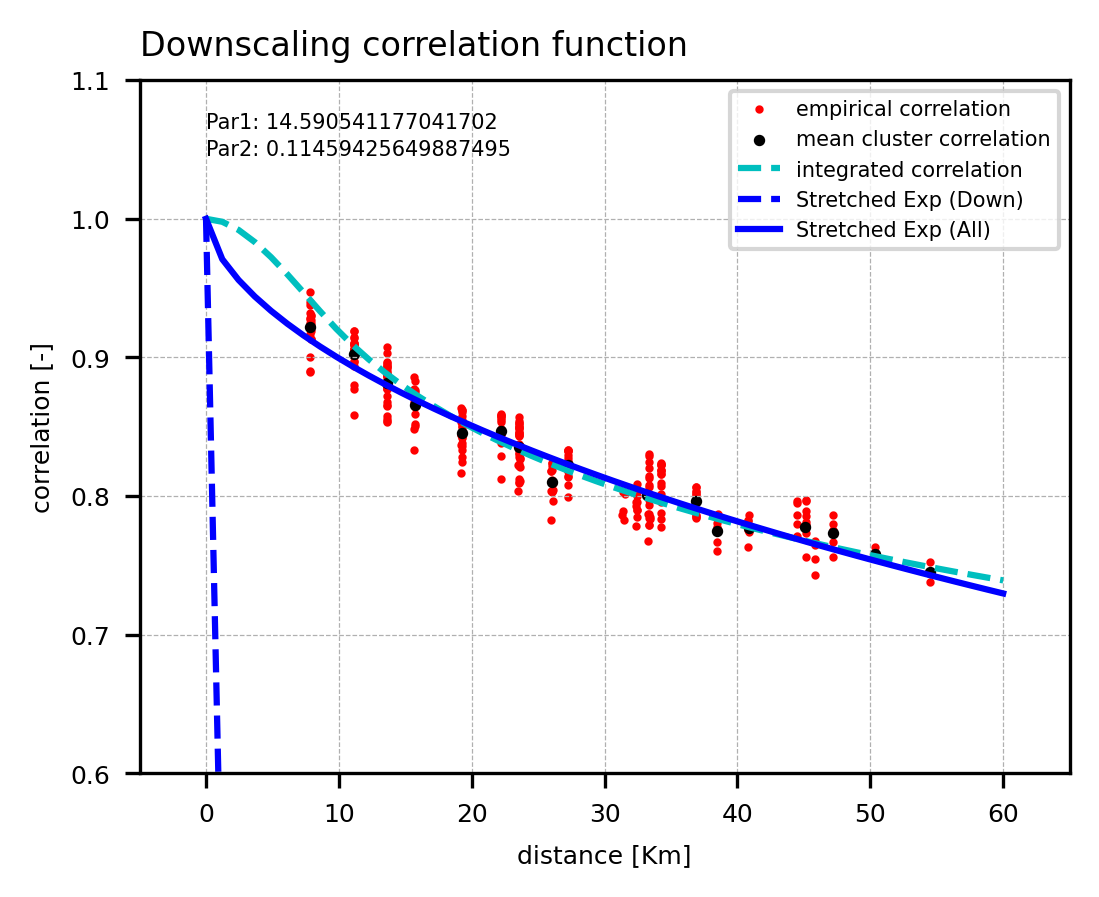

In [198]:
fig = plt.figure(figsize=(4,3),dpi=300)
gs = gridspec.GridSpec(1,1)

ax1 = plt.subplot(gs[0, 0])
ax1.scatter(res['vdist'], res['vcorr'], s=1, c='r', label='empirical correlation')
ax1.scatter(res['vdist_ave'], res['vcorr_ave'], s=3, c='k', label='mean cluster correlation')

ax1.plot(xx, corrL, '--c', label='integrated correlation')

ax1.annotate(f'Par1: {par_acf[0]}', xy=(0, 1.07), xytext=(0, 1.07),
            textcoords='data', fontsize=5, color='black',
            ha='left', va='center')
ax1.annotate(f'Par2: {par_acf[1]}', xy=(0, 1.05), xytext=(0, 1.05),
            textcoords='data', fontsize=5, color='black',
            ha='left', va='center')

if acf == 'mar':
    ax1.plot(xx, down.epl_fun(xx, res['eps_d'],res['alp_d']), '--g', label='Exp.-power law (Down)')
    ax1.plot(xx, down.epl_fun(xx, res['eps_s'], res['alp_s']), '--b', label='Exp.-power law (All)')
elif acf == 'str':
    ax1.plot(xx, down.str_exp_fun(xx, res['d0_d'],res['mu0_d']), '--b', label='Stretched Exp (Down)')
    ax1.plot(xx, down.str_exp_fun(xx, res['d0_s'], res['mu0_s']), 'b',label='Stretched Exp (All)')

ax1.set_xlim([-5, min(100, 10*(np.round(np.max(vdist))//10+1.5))])
ax1.set_ylim([0.6, 1.1])

ax1.grid(linewidth=0.3, linestyle='--')
ax1.legend(fontsize = 5)

ax1.xaxis.set_tick_params(labelsize=6)
ax1.yaxis.set_tick_params(labelsize=6)

ax1.set_title('Downscaling correlation function', fontsize=8, loc='left')
ax1.set_xlabel('distance [Km]', fontsize=6)
ax1.set_ylabel('correlation [-]', fontsize=6)

## Downscaling the Weibull pdf

### down_wei(Ns, Cs, Ws, L1, L0, res['beta'], par_acf, acf=acf)

### Downscaling Weibull for all series

In [185]:
Nd, Cd, Wd, gam_d, fval_w = down.down_wei(Ns, Cs, Ws, L1, L0, res['beta'], par_acf, acf=acf)
Nd, Cd, Wd, gam_d, fval_w
print(f'Weibull Down Wet-days: {Nd}')
print(f'Weibull Down Scale   : {Cd}')
print(f'Weibull Down Shape   : {Wd}')
print(f'Gamma between L1-L0  : {gam_d}')

Gamma value: 0.47421350966114145
warning - downscaling function:: there is something wrong solving fsolve!
Weibull Down Wet-days: 2373.0
Weibull Down Scale   : 13.888985343648612
Weibull Down Shape   : 29244.597052221216
Gamma between L1-L0  : 0.47421350966114145


In [186]:
print('Downscaling pdf - yearly Weibull parameters')
NCWy, YEARSy = down.fit_yearly_weibull(tsc, thresh=thresh, maxmiss=300)
NYd, CYd, WYd, gamYd, _ = down.down_wei(NCWy[:,0], NCWy[:,1], NCWy[:,2], L1, L0, res['beta'], par_acf, acf=acf)

Downscaling pdf - yearly Weibull parameters
Gamma value: 0.47421350966114145


## Downscaling Results

Export as: ../fig/down_v2/Veneto_IMERG_Coast_Level_2001_2017_weibull_OVERLAP_1mm_str_17.png


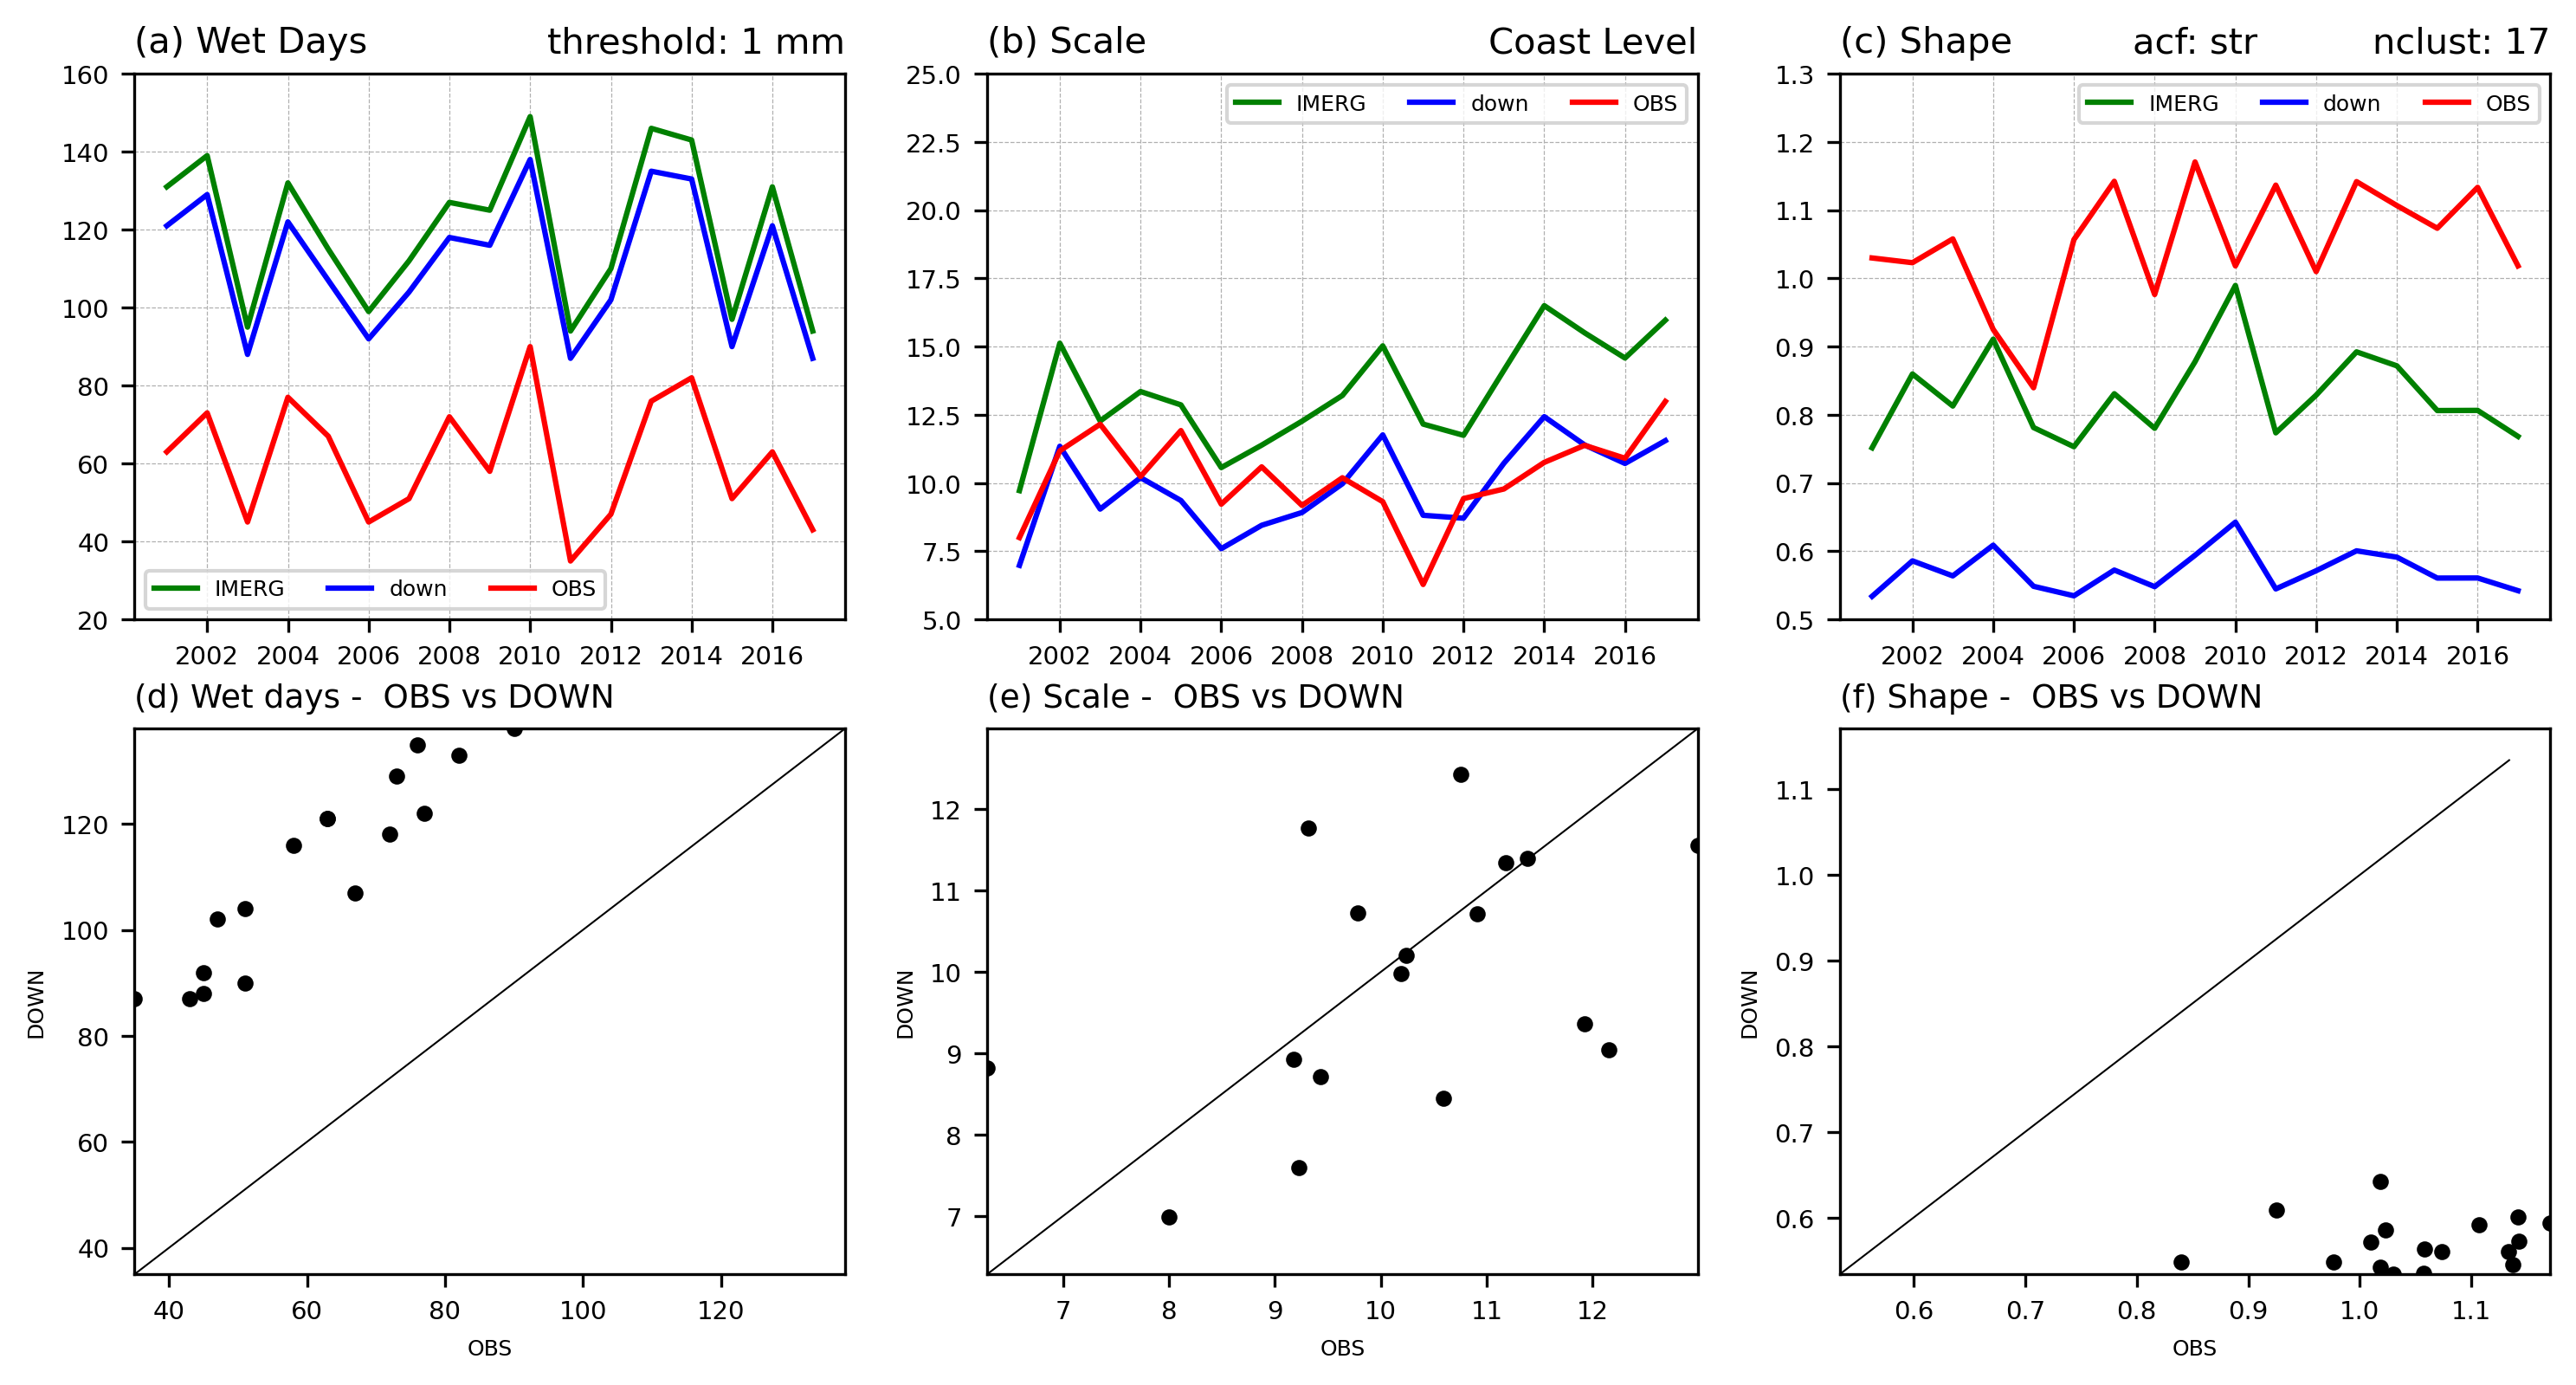

In [199]:
fig = plt.figure(figsize=(12,6),dpi=300)
gs = gridspec.GridSpec(2,3)

ax1 = plt.subplot(gs[0,0])
ax1.plot(YEARSy, NCWy[:,0], c='g', label='IMERG')
ax1.plot(YEARSy, NYd, c='b', label='down')
ax1.plot(OBS_YEARS, OBS_NCW_1dy[:,0], c='r', label='OBS')
ax1.legend(fontsize=6, ncol=3)
ax1.set_title('(a) Wet Days', loc='left', fontsize=10)
ax1.set_title(f'threshold: {thresh} mm', loc='right', fontsize=10)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)
ax1.set_ylim(20,160)
ax1.grid(linewidth=0.3, linestyle='--')

ax1 = plt.subplot(gs[0,1])
ax1.plot(YEARSy, NCWy[:,1], c='g', label='IMERG')
ax1.plot(YEARSy, CYd, c='b', label='down')
ax1.plot(OBS_YEARS, OBS_NCW_1dy[:,1], c='r', label='OBS')
ax1.legend(fontsize=6, ncol=3)
ax1.set_title('(b) Scale', loc='left', fontsize=10)
ax1.set_title(f'{name}',loc='right',fontsize=10)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)
ax1.set_ylim(5,25)
ax1.grid(linewidth=0.3, linestyle='--')

ax1 = plt.subplot(gs[0,2])
ax1.plot(YEARSy, NCWy[:,2], c='g', label='IMERG')
ax1.plot(YEARSy, WYd, c='b', label='down')
ax1.plot(OBS_YEARS, OBS_NCW_1dy[:,2], c='r', label='OBS')
ax1.legend(fontsize=6, ncol=3)
ax1.set_title('(c) Shape', loc='left', fontsize=10)
ax1.set_title(f'acf: {acf}',loc='center',fontsize=10)
ax1.set_title(f'nclust: {nclust}',loc='right',fontsize=10)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)
ax1.set_ylim(0.5,1.3)
ax1.grid(linewidth=0.3, linestyle='--')

ax1 = plt.subplot(gs[1,0])
x_limits = [np.min([np.min(OBS_NCW_1dy[:,0]),np.min(NYd)]),
        np.max([np.max(OBS_NCW_1dy[:,0]),np.max(NYd)])]
y_limits = [np.min([np.min(OBS_NCW_1dy[:,0]),np.min(NYd)]),
        np.max([np.max(OBS_NCW_1dy[:,0]),np.max(NYd)])]
ax1.scatter(OBS_NCW_1dy[:,0], NYd, s=12, c='k')
ax1.plot(np.arange(x_limits[0], x_limits[1], 0.05),
        np.arange(x_limits[0], x_limits[1], 0.05), linewidth=0.5, c='k')
ax1.set_xlim(x_limits)
ax1.set_ylim(y_limits)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)
ax1.set_xlabel('OBS', fontsize=6)
ax1.set_ylabel('DOWN', fontsize=6)
ax1.set_title('(d) Wet days -  OBS vs DOWN', loc='left', fontsize=9)

ax1 = plt.subplot(gs[1,1])
x_limits = [np.min([np.min(OBS_NCW_1dy[:,1]),np.min(CYd)]),
        np.max([np.max(OBS_NCW_1dy[:,1]),np.max(CYd)])]
y_limits = [np.min([np.min(OBS_NCW_1dy[:,1]),np.min(CYd)]),
        np.max([np.max(OBS_NCW_1dy[:,1]),np.max(CYd)])]
ax1.scatter(OBS_NCW_1dy[:,1], CYd, s=12, c='k')
ax1.plot(np.arange(x_limits[0], x_limits[1], 0.05),
        np.arange(x_limits[0], x_limits[1], 0.05), linewidth=0.5, c='k')
ax1.set_xlim(x_limits)
ax1.set_ylim(y_limits)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)
ax1.set_xlabel('OBS', fontsize=6)
ax1.set_ylabel('DOWN', fontsize=6)
ax1.set_title('(e) Scale -  OBS vs DOWN', loc='left', fontsize=9)

ax1 = plt.subplot(gs[1,2])
x_limits = [np.min([np.min(OBS_NCW_1dy[:,2]),np.min(WYd)]),
        np.max([np.max(OBS_NCW_1dy[:,2]),np.max(WYd)])]
y_limits = [np.min([np.min(OBS_NCW_1dy[:,2]),np.min(WYd)]),
        np.max([np.max(OBS_NCW_1dy[:,2]),np.max(WYd)])]
ax1.scatter(OBS_NCW_1dy[:,2], WYd, s=12, c='k')
ax1.plot(np.arange(x_limits[0], x_limits[1], 0.05),
        np.arange(x_limits[0], x_limits[1], 0.05), linewidth=0.5, c='k')
ax1.set_xlim(x_limits)
ax1.set_ylim(y_limits)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)
ax1.set_xlabel('OBS', fontsize=6)
ax1.set_ylabel('DOWN', fontsize=6)
ax1.set_title('(f) Shape -  OBS vs DOWN', loc='left', fontsize=9)

image_dir = f'../fig/down_v2/Veneto_IMERG_{name.replace(' ','_')}_{yy_s}_{yy_e}_weibull_{fig_val}_{thresh}mm_{acf}_{nclust}.png'
print(f'Export as: {image_dir}')
plt.savefig(image_dir,transparent = False,bbox_inches ='tight',pad_inches = 0, facecolor=None)

## Gamma Scales Comparison

In [174]:
# OBS: the error in figure is because the code (vrf) was changed for point and not for L0
# between scale L and a point
# gam  = 4/L**4*int_XY 
# between scales L and L0
# gam = (L0 / L) ** 4 * (int_XY / int_XY0)  

L_tarjet = np.array([10, 9.5, 9, 8.5, 8, 7.5, 7, 6.5, 6, 5.5, 5, 4.5, 4, 3.5, 3, 2.5, 2, 1.5, 1, 0.5, 0.1, target_x])
gam_tmp = []
for target in L_tarjet:
    gam_tmp.append(down.vrf(L1, target, par_acf, acf=acf)) # for down parameters
    # gam_tmp.append(down.vrf(L1, target, (res['d0_s'], res['mu0_s']), acf=acf)) # daily rainfall serie
pos_L_tarjet = np.where(L_tarjet==target_x)[0][0]
print(f'Gamma tarject: {gam_tmp[pos_L_tarjet]}')

Gamma tarject: 0.6050780413721484


Text(1.0, 1.0, '0.6050780413721484')

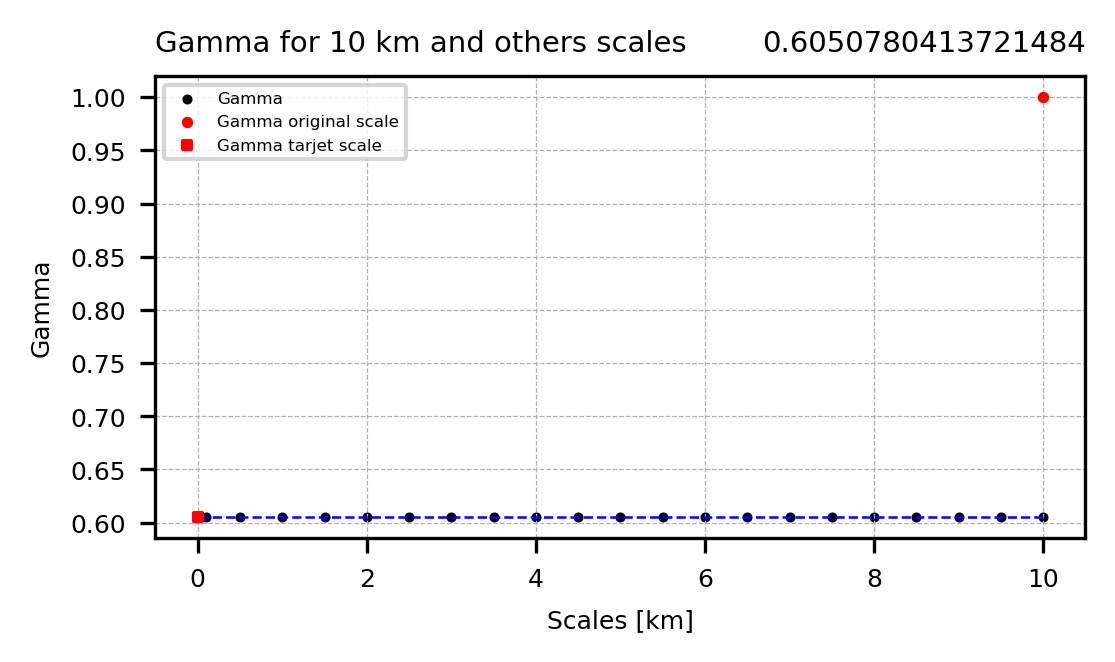

In [175]:
fig = plt.figure(figsize=(4,2),dpi=300)
gs = gridspec.GridSpec(1,1)

ax1 = plt.subplot(gs[0, 0])

ax1.plot(L_tarjet, gam_tmp, '--', c='b', linewidth=0.6)
ax1.scatter(L_tarjet, gam_tmp, s=2, c='k', label='Gamma')
ax1.scatter(10, 1, s=3, c='r', label='Gamma original scale', zorder=5)
ax1.scatter(target_x, gam_tmp[pos_L_tarjet], s=3, c='r', marker='s', label='Gamma tarjet scale', zorder=5)

ax1.grid(linewidth=0.3, linestyle='--')

ax1.xaxis.set_tick_params(labelsize=6)
ax1.yaxis.set_tick_params(labelsize=6)
ax1.legend(fontsize=4)
ax1.set_xlabel('Scales [km]', fontsize=6)
ax1.set_ylabel('Gamma', fontsize=6)
ax1.set_title('Gamma for 10 km and others scales', loc='left', fontsize=7)
ax1.set_title(f'{gam_tmp[pos_L_tarjet]}', loc='right', fontsize=7)

In [77]:
# dcorr =  down.down_corr(rcorr['vdist'], rcorr['vcorr'], L1, acf=acf,
#                     use_ave=True, toll=0.005, opt_method='genetic', #default:'genetic', 'lbfgsb'
#                     plot=True)

In [78]:
# gam_s = down.vrf(L1, L0, (res['{}_s'.format(parnames[0])],
#                         res['{}_s'.format(parnames[1])]), acf=acf)
# print(f'Variance Reduction: {gam_s}')

In [79]:
# print('Downscaling pdf - global Weibull parameters')
# par_acf = (dcorr['{}_d'.format(parnames[0])], dcorr['{}_d'.format(parnames[1])])

# Nd, Cd, Wd, gam_d, fval_w = down.down_wei(Ns, Cs, Ws, L1, L0, res['beta'], par_acf, acf=acf)



# NYd, CYd, WYd, _, _ = down.down_wei(NCWy[:,0], NCWy[:,1], NCWy[:,2], L1, L0, res['beta'], par_acf, acf=acf)

In [80]:
# print('Downscaling pdf - yearly Weibull parameters')
# NCWy, YEARSy = down.fit_yearly_weibull(tsc, thresh=thresh, maxmiss=maxmiss)
# IMERG_N, IMERG_C, IMERG_W = down.wei_fit(IMERG_pixel_1dy, 1)

In [81]:
# print(f'OBS daily Weibull Parameters  : {OBS_N}, {OBS_C}, {OBS_W}')
# print(f'IMERG daily Weibull Parameters: {IMERG_N}, {IMERG_C}, {IMERG_W}')

In [82]:
# res['NYs'] = NCWy[:,0] # yearly Weibull parameters
# res['CYs'] = NCWy[:,1] # yearly Weibull parameters
# res['WYs'] = NCWy[:,2] # yearly Weibull parameters
# res['NYd'] = NYd # Nd, Cd, Wd (downscaled parameters)
# res['CYd'] = CYd # Nd, Cd, Wd (downscaled parameters)
# res['WYd'] = WYd # Nd, Cd, Wd (downscaled parameters)

In [83]:
# Tr = np.array([10, 20, 50, 100]) # pass
# Fi = 1-1/Tr
# res['Tr'] = Tr
# # x0 = 150.0
# x0 = 9.0*np.mean(CYd)
# res['mev_d'] = down.mev_quant(Fi, x0, NYd, CYd, WYd, thresh=thresh)[0] # Computes the MEV quantile for given non exceedance probability
# res['mev_s'] = down.mev_quant(Fi, x0, NCWy[:,0], NCWy[:,1], NCWy[:,2],thresh=thresh)[0] # Computes the MEV quantile for given non exceedance probability

# res['gam_d'] = gam_d # variance reduction function downscale
# # res['gam_s'] = gam_s # variance reduction factor
# res['Nd'] = Nd # Nd, Cd, Wd (downscaled parameters)
# res['Cd'] = Cd # Nd, Cd, Wd (downscaled parameters)
# res['Wd'] = Wd # Nd, Cd, Wd (downscaled parameters)
# res['Ns'] = Ns # global Weibull parameters
# res['Cs'] = Cs # global Weibull parameters
# res['Ws'] = Ws # global Weibull parameters
# # res['{}_s'.format(parnames[0])] = rcorr['{}_s'.format(parnames[0])]
# # res['{}_s'.format(parnames[1])] = rcorr['{}_s'.format(parnames[1])]
# # res['{}_d'.format(parnames[0])] = dcorr['{}_d'.format(parnames[0])]
# # res['{}_d'.format(parnames[1])] = dcorr['{}_d'.format(parnames[1])]
# # res['corr_down_success'] =        dcorr['success']
# # res['corr_down_funval'] =         dcorr['funval']
# res['w_down_funval'] = fval_w[0] # function value at the end of numerical minimization
# res['thresh'] = thresh # threshold used in the analysis
# res['clat'] = clat
# res['clon'] = clon

In [84]:
# DF_WEIBULL = pd.DataFrame({
#                 'NY_IMERG': res['NYs'],
#                 'NY_DOWN': res['NYd'],
#                 'NY_OBS': OBS_NCW_1dy[:,0],
#                 'CY_IMERG': res['CYs'],
#                 'CY_DOWN': res['CYd'],
#                 'CY_OBS': OBS_NCW_1dy[:,1],
#                 'WY_IMERG': res['WYs'],
#                 'WY_DOWN': res['WYd'],
#                 'WY_OBS': OBS_NCW_1dy[:,2],
#                 })
# DF_WEIBULL.head(3)

In [85]:
# DF_dir = f'../data/weibull_threshold/Weibull_{name.replace(' ','_')}_{fig_val}_{thresh}mm.csv'
# print(f'Export as: {DF_dir}')
# # DF_WEIBULL.to_csv(DF_dir, index=False, header=True)

In [86]:
# fig = plt.figure(figsize=(4,7.5),dpi=300)
# gs = gridspec.GridSpec(3,1)

# # =================================================================
# ax1 = plt.subplot(gs[0, 0])
# ax1.plot(YEARSy, res['NYs'], label=f'IMERG')
# ax1.plot(YEARSy, res['NYd'], c='k', linewidth=0.5, label=f'DOWN')
# ax1.plot(OBS_YEARS, OBS_NCW_1dy[:,0], c='r', label=f'OBS')

# ax1.legend(fontsize=5)
# ax1.grid(linestyle='--', linewidth=0.3)
# ax1.set_title('(a) Number of wet days',loc='left',fontsize=6)
# ax1.set_title(f'Beta: {np.round(res['beta'],4)}',loc='right',fontsize=6)
# ax1.set_title(f'{name} (> {thresh} mm)',loc='center',fontsize=6)
# ax1.set_ylabel('Days', fontsize=5)

# ax1.xaxis.set_tick_params(labelsize=5)
# ax1.yaxis.set_tick_params(labelsize=5)

# # =================================================================
# ax1 = plt.subplot(gs[1, 0])
# ax1.plot(YEARSy, res['CYs'], label=f'IMERG')
# ax1.plot(YEARSy, res['CYd'], c='k', linewidth=0.5, label=f'DOWN')
# ax1.plot(OBS_YEARS, OBS_NCW_1dy[:,1], c='r', label=f'OBS')
# ax1.set_title(f'{yy_s} - {yy_e}',loc='right',fontsize=6)

# ax1.legend(fontsize=5)
# ax1.grid(linestyle='--', linewidth=0.3)
# ax1.set_title('(b) Scale Parameter',loc='left',fontsize=6)
# ax1.set_ylabel('Scale', fontsize=5)

# ax1.xaxis.set_tick_params(labelsize=5)
# ax1.yaxis.set_tick_params(labelsize=5)

# # =================================================================
# ax1 = plt.subplot(gs[2, 0])
# ax1.plot(YEARSy, res['WYs'], label=f'IMERG')
# ax1.plot(YEARSy, res['WYd'], c='k', linewidth=0.5, label=f'DOWN')
# ax1.plot(OBS_YEARS, OBS_NCW_1dy[:,2], c='r', label=f'OBS')

# ax1.legend(fontsize=5)
# ax1.grid(linestyle='--', linewidth=0.3)
# ax1.set_title('(c) Shape Parameter',loc='left',fontsize=6)
# ax1.set_ylabel('Shape', fontsize=5)
# ax1.set_xlabel('Years', fontsize=5)

# ax1.xaxis.set_tick_params(labelsize=5)
# ax1.yaxis.set_tick_params(labelsize=5)

# #==================================================================================================
# image_dir = f'../fig/Veneto_IMERG_{name.replace(' ','_')}_{yy_s}_{yy_e}_weibull_{fig_val}_{thresh}mm.png'
# print(f'Export as: {image_dir}')
# # plt.savefig(image_dir,transparent = False,bbox_inches ='tight',pad_inches = 0, facecolor=None)

In [87]:
# cmap = plt.cm.Spectral_r
# proj = ccrs.PlateCarree()

# fig = plt.figure(figsize=(10,10),dpi=200)
# gs = gridspec.GridSpec(3,2)

# # ============================================================================================================================
# # ============================================================================================================================

# max_ref = np.max((np.max(OBS_NCW_1dy[:,0]), np.max(res['NYd'])))
# min_ref = np.min((np.min(OBS_NCW_1dy[:,0]), np.min(res['NYd'])))
# ax1 = plt.subplot(gs[0, 0])

# ax1.scatter(OBS_NCW_1dy[:,0], res['NYd'], c='k', s=18, label='Scatter')
# ax1.plot(np.arange(min_ref,max_ref),np.arange(min_ref,max_ref), '--', color='k', linewidth=0.4, label='Identity line')

# slope, intercept, _, _, _ = stats.linregress(OBS_NCW_1dy[:,0], res['NYd'])
# ax1.plot(np.arange(min_ref,max_ref), slope*np.arange(min_ref,max_ref) + intercept, '--', color='r', linewidth=0.6, label='Linear Regression')

# ax1.grid(linewidth=0.1, linestyle='--')
# ax1.set_xlim(min_ref-6, max_ref+6)
# ax1.set_ylim(min_ref-6, max_ref+6)
# ax1.xaxis.set_tick_params(labelsize=7)
# ax1.yaxis.set_tick_params(labelsize=7)

# ax1.legend(fontsize=5, loc=2)
# ax1.set_title('(a) # wet days (OBS vs DOWN)', loc='left', fontsize=8)
# ax1.set_title(f'{yy_s} - {yy_e}', loc='right', fontsize=8)

# # ==============================================================================================
# max_ref = np.max((np.max(OBS_NCW_1dy[:,1]), np.max(res['CYd'])))
# min_ref = np.min((np.min(OBS_NCW_1dy[:,1]), np.min(res['CYd'])))
# ax1 = plt.subplot(gs[1, 0])

# ax1.scatter(OBS_NCW_1dy[:,1], res['CYd'], c='k', s=18, label='Scatter')
# ax1.plot(np.arange(min_ref,max_ref),np.arange(min_ref,max_ref), '--', color='k', linewidth=0.4, label='Identity line')

# slope, intercept, _, _, _ = stats.linregress(OBS_NCW_1dy[:,1], res['CYd'])
# ax1.plot(np.arange(min_ref,max_ref), slope*np.arange(min_ref,max_ref) + intercept, '--', color='r', linewidth=0.6, label='Linear Regression')

# ax1.grid(linewidth=0.1, linestyle='--')
# ax1.set_xlim(min_ref-1, max_ref+1)
# ax1.set_ylim(min_ref-1, max_ref+1)
# ax1.xaxis.set_tick_params(labelsize=7)
# ax1.yaxis.set_tick_params(labelsize=7)

# ax1.legend(fontsize=5, loc=2)
# ax1.set_title('(b) Scale parameter (OBS vs DOWN)', loc='left', fontsize=8)

# # ==============================================================================================
# max_ref = np.max((np.max(OBS_NCW_1dy[:,2]), np.max(res['WYd'])))
# min_ref = np.min((np.min(OBS_NCW_1dy[:,2]), np.min(res['WYd'])))
# ax1 = plt.subplot(gs[2, 0])

# ax1.scatter(OBS_NCW_1dy[:,2], res['WYd'], c='k', s=18, label='Scatter')
# ax1.plot(np.arange(min_ref,max_ref, 0.01),np.arange(min_ref,max_ref, 0.01), '--', color='k', linewidth=0.4, label='Identity line')

# slope, intercept, _, _, _ = stats.linregress(OBS_NCW_1dy[:,2], res['WYd'])
# ax1.plot(np.arange(min_ref,max_ref, 0.01), slope*np.arange(min_ref,max_ref, 0.01) + intercept, '--', color='r', linewidth=0.6, label='Linear Regression')

# ax1.grid(linewidth=0.1, linestyle='--')
# ax1.set_xlim(min_ref-0.02, max_ref+0.02)
# ax1.set_ylim(min_ref-0.02, max_ref+0.02)
# ax1.xaxis.set_tick_params(labelsize=7)
# ax1.yaxis.set_tick_params(labelsize=7)

# ax1.legend(fontsize=5, loc=2)
# ax1.set_title('(c) Shape parameter (OBS vs DOWN)', loc='left', fontsize=8)

# # ============================================================================================================================
# # ============================================================================================================================
# quant, flags = down.mev_quant(Fi, 0, OBS_NCW_1dy[:,0], OBS_NCW_1dy[:,1], OBS_NCW_1dy[:,2], thresh=1)
# ax1 = plt.subplot(gs[0, 1])
# ax1.plot(Tr, res['mev_s'], label='IMERG')
# ax1.plot(Tr, res['mev_d'], c='k', label='Downscale')
# ax1.plot(Tr, quant, c='r', label='Raingauge')

# ax1.grid(linewidth=0.1, linestyle='--')
# ax1.xaxis.set_tick_params(labelsize=7)
# ax1.yaxis.set_tick_params(labelsize=7)

# ax1.legend(fontsize=5, loc=2)
# ax1.set_title('(d) Return Time vs Quantile (Annual Rainfall)', loc='left', fontsize=8)
# ax1.set_title(f'> {thresh} mm',loc='right',fontsize=8)

# # ==============================================================================================
# x = np.linspace(0, 200, 1000)
# OBS_N, OBS_scale, OBS_shape = down.wei_fit(OBS_xr.data)
# OBS_pdf = weibull_min.pdf(x, OBS_shape, scale=OBS_scale)
# IMERG_pdf = weibull_min.pdf(x, res['Ws'], scale=res['Cs'])
# DOWN_pdf = weibull_min.pdf(x, res['Wd'], scale=res['Cd'])

# ax1 = plt.subplot(gs[1, 1])
# ax1.plot(x, IMERG_pdf, linewidth=2, label='IMRERG')
# ax1.plot(x, DOWN_pdf, c='k', linewidth=1, label='Downscaling')
# ax1.plot(x, OBS_pdf,  c='r', label='Raingauge')

# ax1.grid(linewidth=0.1, linestyle='--')
# ax1.xaxis.set_tick_params(labelsize=7)
# ax1.yaxis.set_tick_params(labelsize=7)

# ax1.legend(fontsize=5, loc=0)
# ax1.set_title('(e) Weibull Probability Density Function (PDF)', loc='left', fontsize=8)

# # ==============================================================================================
# x = np.linspace(0, 200, 1000)
# OBS_cdf = weibull_min.cdf(x, OBS_shape, scale=OBS_scale)
# IMERG_cdf = weibull_min.cdf(x, res['Ws'], scale=res['Cs'])
# DOWN_cdf = weibull_min.cdf(x, res['Wd'], scale=res['Cd'])

# ax1 = plt.subplot(gs[2, 1])
# ax1.plot(x, IMERG_cdf, linewidth=2, label='IMRERG')
# ax1.plot(x, DOWN_cdf, c='k', linewidth=1, label='Downscaling')
# ax1.plot(x, OBS_cdf,  c='r', label='Raingauge')

# ax1.grid(linewidth=0.1, linestyle='--')
# ax1.xaxis.set_tick_params(labelsize=7)
# ax1.yaxis.set_tick_params(labelsize=7)

# ax1.legend(fontsize=5, loc=0)
# ax1.set_title('(f) Weibull Cumulative Distribution Function (CDF)', loc='left', fontsize=8)
# # ============================================================================================================================
# # ============================================================================================================================
# plt.subplots_adjust(hspace=0.2,wspace=0.15)

# image_dir = f'../fig/down_v1/Veneto_IMERG_{name.replace(' ','_')}_{yy_s}_{yy_e}_stats_{fig_val}_{thresh}mm.png'
# print(f'Export as: {image_dir}')
# # plt.savefig(image_dir,transparent = False,bbox_inches ='tight',pad_inches = 0, facecolor=None)

In [88]:
# PIXELS = [3, 5, 7, 9]

# BETA_ZORZETO = [
#     1.0735330179780285,
#     1.0755179214412498,
#     1.083904251343893,
#     1.0771642585813794
# ]

# BETA_EXTRAPOLATE = [
#     1.0845262668044167,
#     1.0862029960444097,
#     1.093423401697024,
#     1.0856505401489938
# ]

In [89]:
# fig = plt.figure(figsize=(4,2),dpi=300)
# gs = gridspec.GridSpec(1,1)

# # ============================================================================================================================
# ax1 = plt.subplot(gs[0, 0])
# ax1.plot(PIXELS, BETA_ZORZETO, '.', color='r')
# ax1.plot(PIXELS, BETA_ZORZETO, '--', color='r', label='Beta Zorzeto')
# ax1.plot(PIXELS, BETA_EXTRAPOLATE, '.',color='b')
# ax1.plot(PIXELS, BETA_EXTRAPOLATE, '--',color='b', label='Beta extrapolation')

# ax1.grid(linewidth=0.3, linestyle='--')
# ax1.legend(fontsize=5)

# ax1.xaxis.set_tick_params(labelsize=5)
# ax1.yaxis.set_tick_params(labelsize=5)
# ax1.set_xlabel('Number of Pixels', fontsize=6)
# ax1.set_ylabel('Beta', fontsize=6)
# ax1.set_title('Beta Variation with Respect to the Number of Pixels', loc='left', fontsize=5)
# ax1.set_title('middle level', loc='right', fontsize=5)

In [90]:
playsound("../sound/HOMER_DOH.mp3")